In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def B(m1, si, mmax, mmin):
    if m1 > mmax:
        return 0
    if m1 < mmin:
        return 0
    return m1 ** si

In [3]:
def G(m1, mum, sigmam):
    return math.exp(-0.5 * ((m1 - mum) / sigmam) ** 2)

In [4]:
def f(m, deltam):
    return math.exp(deltam / m + deltam / (m - deltam))

In [5]:
def S(m, mmin, deltam):
    if m < mmin:
        return 0
    elif mmin <= m < mmin + deltam:
        return (f(m - mmin, deltam) + 1) ** -1
    elif m >= mmin + deltam:
        return 1
    else:
        raise ValueError()

In [6]:
def pi_pp(m1, lpeak, alpha, mmin, deltam, mmax, mum, sigmam):
    t1 = (1 - lpeak) * B(m1, -alpha, mmax, mmin)
    t2 = lpeak * G(m1, mum, sigmam)
    return (t1 + t2) # * S(m1, mmin, deltam)

In [7]:
sigmam = 5.69
mum = 33.07
lpeak = 0.1
mmax = 86.22
mmin = 4.59
deltam = 4.82
betaq = 1.26
alpha=2.63

In [8]:
densities = []

In [9]:
M1 = np.linspace(0, mmax + 16, num=256)

Text(0.5, 1.0, '$B(m_1|-\\alpha, m_{max})$')

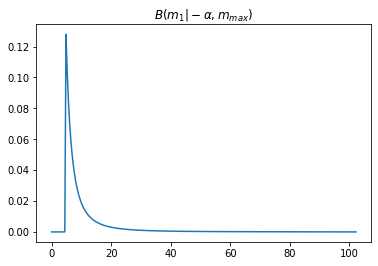

In [10]:
densities_b = []
for m1 in M1:
    densities_b.append(B(m1, -alpha, mmax, mmin))

densities_b = np.array(densities_b)
Z_b = np.sum(densities_b)
densities_b /= Z_b
plt.plot(M1, densities_b)
plt.title('$B(m_1|-\\alpha, m_{max})$')

Text(0.5, 1.0, '$G(m_1|\\mu_m, \\sigma_m)$')

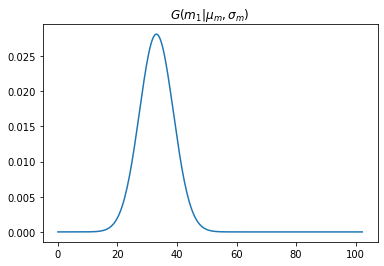

In [11]:
densities_g = []
for m1 in M1:
    densities_g.append(G(m1, mum, sigmam))

densities_g = np.array(densities_g)
densities_g /= np.sum(densities_g)
plt.plot(M1, densities_g)
plt.title('$G(m_1|\\mu_m, \\sigma_m)$')

In [12]:
np.sum(densities_g)

1.0000000000000002

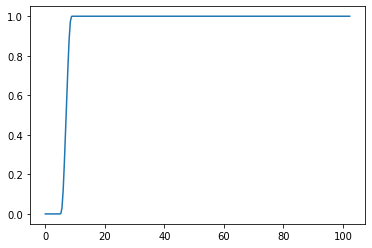

In [13]:
ss = []
for m1 in M1:
    ss.append(S(m1, mmin, deltam))
    
ss = np.array(ss)
plt.plot(M1, ss)

In [14]:
pi = ((1 - lpeak) * densities_b + lpeak * densities_g) * ss

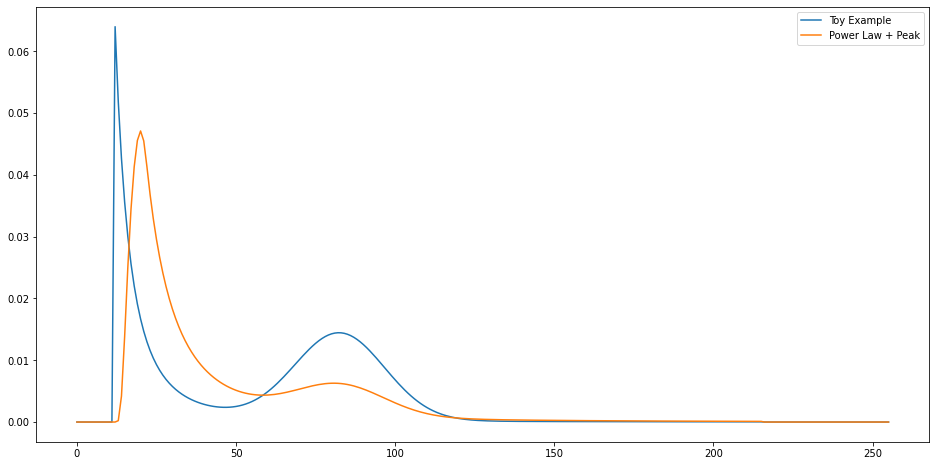

In [15]:
plt.figure(figsize=(16, 8))

pi_ =  densities_b + densities_g

plt.plot(pi_ / pi_.sum(), label='Toy Example')
plt.plot(pi / pi.sum(), label ='Power Law + Peak')
plt.legend()

In [16]:
def sample_powerlaw(n, alpha, xmin):
    # p(x) = x^alpha
    u = np.random.rand(n)
    return xmin * ( 1- u) ** (1 / (1 + alpha))

In [17]:
import seaborn as sns

In [18]:
total_samples = 2 ** 16


p_n = int((1 - lpeak) * total_samples)
p_g = total_samples - p_n

In [19]:
p_samples = sample_powerlaw(p_n, -alpha, mmin)
p_samples = p_samples[p_samples < mmax]

In [20]:
g_samples = np.random.randn(p_g) * sigmam + mum

In [21]:
samples = np.concatenate([p_samples, g_samples])

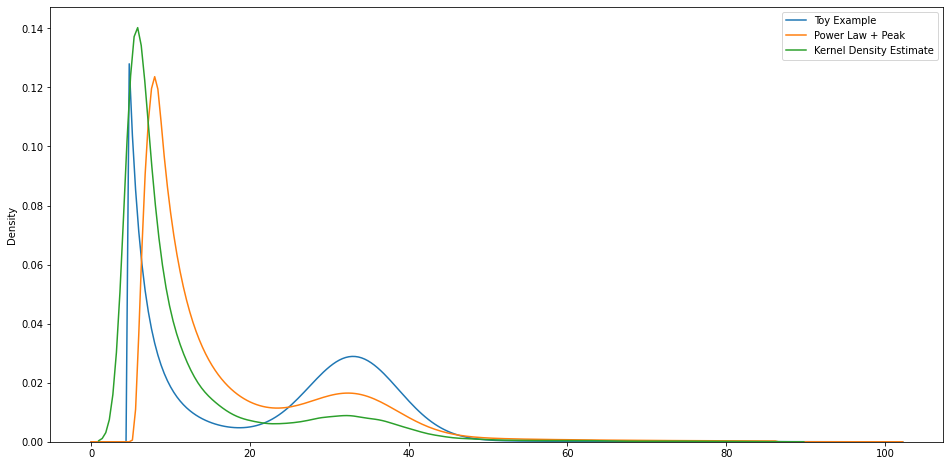

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(M1, pi_ / (pi_.sum() - 1), label='Toy Example')
plt.plot(M1, pi / (pi.sum() - .35), label ='Power Law + Peak')
sns.kdeplot(samples, label='Kernel Density Estimate')
plt.legend()


In [23]:
M1[pi_.argmax()]

4.81035294117647

In [24]:
p_samples.min()

4.590004654519299

In [25]:
mum

33.07

In [26]:
from torch.distributions import Distribution, Normal

In [27]:
import torch

class PowerLaw(Distribution):
    """p(x) = x^alpha, x > xmin"""
    def __init__(self, alpha, xmin):
        self.alpha = alpha
        self.xmin = xmin
        super().__init__(validate_args=False)
        
    def pdf(self, x):
        assert not torch.any(x < self.xmin), x
 
        return (-self.alpha - 1) / self.xmin * (x / self.xmin) ** (self.alpha)
    
    def log_prob(self, x):
        return self.pdf(x).log()
    
    def sample(self, size):
        u = torch.rand(size)
        return self.icdf(u)
    
    def icdf(self, u):
        return self.xmin * ( 1- u) ** (1 / (1 + self.alpha))

In [28]:
p = PowerLaw(-alpha, mmin)

In [29]:
m1 = p.sample((128)).numpy()

In [30]:
n = Normal(0, 1)

In [31]:
class Mixture(torch.distributions.Distribution):
    def __init__(self, distributions, weights) -> None:
        assert sum(weights) == 1
        self.distributions = distributions
        self.weights = weights

    def sample(self, n):
        assert isinstance(n, int)
        samples = []
        nums = []
        for i in range(len(self.weights) - 1):
            nums.append(int(self.weights[i] * n))
        nums.append(n - sum(nums))
        
        for i in range(len(self.distributions)):
            num = nums[i]
            samples.append(self.distributions[i].sample((num,)))

        samples = torch.cat(samples, dim=0)
        samples = samples[torch.randperm(len(samples))]
        return samples

    def log_prob(self, x):

        log_probs = torch.stack(
            [self.distributions[i].log_prob(x) for i in range(len(self.distributions))]
        )
        log_prob = torch.logsumexp(log_probs, dim=0)
        return log_prob


In [32]:
mix = Mixture((Normal(mum, sigmam), PowerLaw(-alpha, mmin)), (lpeak,  1 - lpeak))


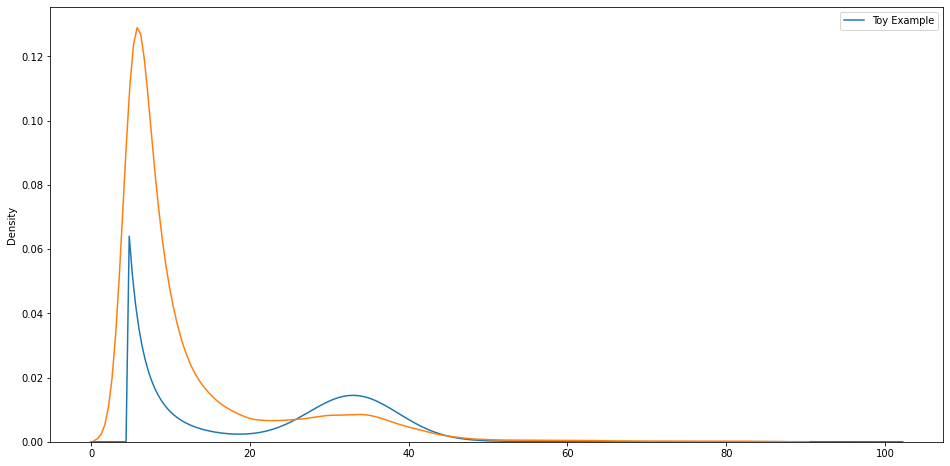

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(M1, pi_ / (pi_.sum()), label='Toy Example')
# plt.plot(M1, pi / (pi.sum()), label='joe')


mix_samples = mix.sample(32768).numpy()
mix_samples = mix_samples[mix_samples < mmax]
sns.kdeplot(mix_samples)
# sns.kdeplot(samples)
plt.legend()

In [34]:
g = Normal(0, 1)

  1%|▍                                              | 307/32768 [00:00<00:10, 3062.90it/s]

0.0 5.393747806549072 0.99
0.0 5.393747806549072 0.9801
0.3333333333333333 6.109690189361572 0.9702989999999999
0.25 6.109690189361572 0.96059601
0.4 5.257612228393555 0.9509900498999999
0.3333333333333333 5.257612228393555 0.9414801494009999
0.42857142857142855 5.673781394958496 0.9320653479069899
0.5 5.918460845947266 0.92274469442792
0.5555555555555556 5.026148796081543 0.9135172474836407
0.6 5.700648307800293 0.9043820750088043
0.5454545454545454 5.700648307800293 0.8953382542587163
0.5833333333333334 5.103212356567383 0.8863848717161291
0.5384615384615384 5.103212356567383 0.8775210229989678
0.5 5.103212356567383 0.8687458127689781
0.5333333333333333 5.730725288391113 0.8600583546412883
0.5625 5.440127849578857 0.8514577710948754
0.5294117647058824 5.440127849578857 0.8429431933839266
0.5555555555555556 5.041238307952881 0.8345137614500874
0.5263157894736842 5.041238307952881 0.8261686238355865
0.55 4.961045265197754 0.8179069375972307
0.5714285714285714 4.638888359069824 0.809727

  3%|█▎                                             | 895/32768 [00:00<00:11, 2742.02it/s]

0.6964980544747081 10.09882640838623 0.7471720943315961
0.6964980544747081 9.45644760131836 0.7397003733882802
0.6964980544747081 9.10125732421875 0.7323033696543974
0.6964980544747081 9.676380157470703 0.7249803359578534
0.6964980544747081 10.087692260742188 0.7177305325982748
0.6964980544747081 9.158735275268555 0.7105532272722921
0.6964980544747081 9.18354320526123 0.7034476949995692
0.6964980544747081 8.44936466217041 0.6964132180495735
0.6964980544747081 8.159985542297363 0.6894490858690777
0.7003891050583657 8.938308715820312 0.682554595010387
0.7003891050583657 8.74301528930664 0.6757290490602831
0.7003891050583657 9.548393249511719 0.6689717585696803
0.7003891050583657 10.398979187011719 0.6622820409839835
0.7003891050583657 10.876761436462402 0.6556592205741436
0.7003891050583657 10.47987174987793 0.6491026283684022
0.7003891050583657 10.027800559997559 0.6426116020847181
0.7003891050583657 9.64763069152832 0.6361854860638709
0.7003891050583657 8.983603477478027 0.629823631203

  5%|██                                            | 1500/32768 [00:00<00:10, 2843.65it/s]

0.6809338521400778 6.9051289558410645 0.270754259511994
0.6848249027237354 7.02546501159668 0.26804671691687404
0.6848249027237354 7.471568584442139 0.2653662497477053
0.6848249027237354 7.9871697425842285 0.2627125872502282
0.688715953307393 7.2431254386901855 0.2600854613777259
0.688715953307393 7.2431254386901855 0.2574846067639487
0.6926070038910506 7.051680088043213 0.2549097606963092
0.6926070038910506 7.190968990325928 0.2523606630893461
0.6964980544747081 7.383742332458496 0.24983705645845267
0.7003891050583657 7.845831871032715 0.24733868589386815
0.7003891050583657 7.996883392333984 0.24486529903492946
0.7042801556420234 7.684609889984131 0.24241664604458016
0.708171206225681 7.89361047744751 0.23999247958413436
0.708171206225681 7.576663970947266 0.23759255478829303
0.7120622568093385 7.445330619812012 0.2352166292404101
0.7120622568093385 7.495822906494141 0.232864462948006
0.7159533073929961 7.939365863800049 0.23053581831852593
0.7159533073929961 8.05675220489502 0.228230

  6%|██▉                                           | 2084/32768 [00:00<00:10, 2859.23it/s]

0.7782101167315175 6.259535312652588 0.18480456394854633
0.7782101167315175 6.190798759460449 0.18295651830906087
0.7821011673151751 6.04433012008667 0.18112695312597027
0.7821011673151751 5.989346981048584 0.17931568359471056
0.7821011673151751 5.882511138916016 0.17752252675876345
0.7821011673151751 6.021605014801025 0.17574730149117582
0.7859922178988327 5.58421516418457 0.17398982847626407
0.7859922178988327 5.624350547790527 0.17224993019150142
0.7898832684824902 5.738733768463135 0.1705274308895864
0.7898832684824902 5.917697429656982 0.16882215658069055
0.7898832684824902 5.614879608154297 0.16713393501488363
0.7898832684824902 5.6229681968688965 0.16546259566473479
0.7898832684824902 5.379578113555908 0.16380796970808745
0.7898832684824902 5.612823009490967 0.16216989001100657
0.7898832684824902 5.538444995880127 0.1605481911108965
0.7898832684824902 5.686964988708496 0.15894270919978754
0.7937743190661478 5.696911334991455 0.15735328210778965
0.7976653696498055 5.8486504554748

  8%|███▊                                          | 2702/32768 [00:00<00:10, 2982.47it/s]

0.8132295719844358 9.07038688659668 0.21272570322901874
0.8132295719844358 8.645955085754395 0.21487444770607952
0.8132295719844358 8.696590423583984 0.2170448966728076
0.8132295719844358 8.730299949645996 0.21923726936647234
0.8171206225680934 8.681334495544434 0.22145178723886094
0.8210116731517509 8.813040733337402 0.22368867397864742
0.8210116731517509 8.960819244384766 0.22594815553398728
0.8249027237354085 9.068970680236816 0.22823046013534068
0.8249027237354085 8.793070793151855 0.23053581831852593
0.8249027237354085 8.830485343933105 0.232864462948006
0.8249027237354085 8.836416244506836 0.2352166292404101
0.8249027237354085 8.721319198608398 0.23759255478829303
0.8249027237354085 8.529757499694824 0.23999247958413436
0.8249027237354085 8.610249519348145 0.24241664604458016
0.8249027237354085 8.44411563873291 0.24486529903492946
0.8287937743190662 8.258036613464355 0.24733868589386815
0.8287937743190662 8.262845993041992 0.24983705645845267
0.8326848249027238 8.304640769958496 

 10%|████▋                                         | 3299/32768 [00:01<00:09, 2959.60it/s]

0.8871595330739299 8.292682647705078 1.0621572856700507
0.8871595330739299 8.068360328674316 1.0728861471414655
0.8871595330739299 8.068360328674316 1.0837233809509752
0.8871595330739299 6.845212936401367 1.0946700817686619
0.8910505836575876 6.367755889892578 1.1057273553218807
0.8910505836575876 7.27362585067749 1.1168963185069503
0.8910505836575876 6.429311275482178 1.12817809950197
0.8910505836575876 6.371891975402832 1.1395738378807776
0.8910505836575876 5.708876609802246 1.1510846847280582
0.8871595330739299 5.708876609802246 1.1627118027556145
0.8832684824902723 5.708876609802246 1.1744563664198127
0.8832684824902723 4.908997058868408 1.1863195620402147
0.8793774319066148 4.908997058868408 1.198302587919409
0.8754863813229572 4.908997058868408 1.2104066544640495
0.8754863813229572 5.625101566314697 1.2226329843071206
0.8754863813229572 6.542541027069092 1.234982812431435
0.8754863813229572 6.358828067779541 1.2474573862943787
0.8715953307392996 6.358828067779541 1.26005796595391

 12%|█████▍                                        | 3914/32768 [00:01<00:09, 2930.66it/s]

0.6964980544747081 6.622745513916016 1.1168963185069503
0.6964980544747081 6.323290824890137 1.1057273553218807
0.6964980544747081 5.807403087615967 1.0946700817686619
0.6964980544747081 6.057647228240967 1.0837233809509752
0.6964980544747081 6.057647228240967 1.0728861471414655
0.6964980544747081 4.749489784240723 1.0621572856700507
0.6964980544747081 6.693277359008789 1.0515357128133502
0.6964980544747081 5.863288879394531 1.0410203556852167
0.6964980544747081 5.489176273345947 1.0306101521283646
0.6926070038910506 5.489176273345947 1.0203040506070808
0.688715953307393 5.489176273345947 1.01010101010101
0.688715953307393 5.539669513702393 0.9999999999999999
0.6926070038910506 6.4635396003723145 0.9899999999999999
0.6926070038910506 8.434549331665039 0.9800999999999999
0.6926070038910506 8.354012489318848 0.9702989999999998
0.6926070038910506 9.9212646484375 0.9605960099999998
0.6964980544747081 11.011381149291992 0.9509900498999998
0.6964980544747081 10.646611213684082 0.941480149400

 14%|██████▎                                       | 4510/32768 [00:01<00:09, 2872.29it/s]

0.6809338521400778 26.73959732055664 4.251400095432541
0.6770428015564203 26.73959732055664 4.208886094478216
0.6731517509727627 26.73959732055664 4.166797233533434
0.6731517509727627 30.8544864654541 4.1251292611981
0.6731517509727627 30.002384185791016 4.083877968586119
0.6731517509727627 32.57194900512695 4.0430391889002575
0.669260700389105 32.57194900512695 4.002608797011255
0.669260700389105 29.648996353149414 3.962582709041142
0.669260700389105 30.805580139160156 3.922956881950731
0.669260700389105 27.457807540893555 3.8837273131312235
0.669260700389105 23.69390106201172 3.8448900399999113
0.6653696498054474 23.69390106201172 3.806441139599912
0.6653696498054474 20.524003982543945 3.7683767282039127
0.6653696498054474 16.760398864746094 3.7306929609218735
0.669260700389105 16.617643356323242 3.693386031312655
0.6731517509727627 14.406118392944336 3.6564521709995286
0.6731517509727627 17.183889389038086 3.619887649289533
0.6731517509727627 15.943581581115723 3.583688772796638
0.6

 15%|███████                                       | 5073/32768 [00:01<00:10, 2612.76it/s]

0.7587548638132295 4.834712982177734 2.520937606819629
0.754863813229572 4.834712982177734 2.495728230751433
0.7509727626459144 4.834712982177734 2.4707709484439184
0.7470817120622568 4.834712982177734 2.4460632389594794
0.7470817120622568 6.175268173217773 2.4216026065698846
0.7431906614785992 6.175268173217773 2.3973865805041856
0.7431906614785992 6.7558369636535645 2.373412714699144
0.7470817120622568 4.81970739364624 2.3496785875521526
0.7431906614785992 4.81970739364624 2.326181801676631
0.7431906614785992 5.429069995880127 2.3029199836598644
0.7431906614785992 5.970402240753174 2.279890783823266
0.7431906614785992 8.368508338928223 2.2570918759850334
0.7392996108949417 8.368508338928223 2.234520957225183
0.7392996108949417 10.21246337890625 2.212175747652931
0.7392996108949417 5.19925594329834 2.1900539901764016
0.7354085603112841 5.19925594329834 2.1681534502746374
0.7354085603112841 4.753188133239746 2.146471915771891
0.7315175097276264 4.753188133239746 2.1250071966141717
0.72

 17%|███████▉                                      | 5628/32768 [00:02<00:10, 2617.27it/s]

0.8054474708171206 31.84548568725586 7.02703712633359
0.8093385214007782 30.24951171875 7.098017299326859
0.8093385214007782 29.230426788330078 7.169714443764504
0.8132295719844358 27.576208114624023 7.242135801782328
0.8132295719844358 33.51963806152344 7.3152886886690185
0.8093385214007782 33.51963806152344 7.389180493605069
0.8054474708171206 33.51963806152344 7.463818680409161
0.8015564202334631 33.51963806152344 7.539210788292082
0.7976653696498055 33.51963806152344 7.463818680409161
0.7937743190661478 33.51963806152344 7.389180493605069
0.7937743190661478 30.025753021240234 7.3152886886690185
0.7898832684824902 30.025753021240234 7.242135801782328
0.7898832684824902 36.21734619140625 7.169714443764504
0.7898832684824902 31.434526443481445 7.098017299326859
0.7859922178988327 31.434526443481445 7.02703712633359
0.7859922178988327 29.647052764892578 6.956766755070253
0.7821011673151751 29.647052764892578 6.887199087519551
0.7821011673151751 31.357267379760742 6.818327096644355
0.78

 19%|████████▋                                     | 6202/32768 [00:02<00:09, 2740.92it/s]

0.8910505836575876 9.2874116897583 0.7105532272722921
0.8949416342412452 9.45783519744873 0.7177305325982748
0.8988326848249028 9.596400260925293 0.7249803359578534
0.9027237354085603 7.73249626159668 0.7323033696543974
0.9027237354085603 7.01756477355957 0.7397003733882802
0.9066147859922179 6.887340068817139 0.7471720943315961
0.9066147859922179 6.005600929260254 0.7547192872036325
0.9105058365758755 5.897883892059326 0.7623427143471035
0.9105058365758755 6.080129623413086 0.7700431458051551
0.9105058365758755 6.015107154846191 0.7778213593991465
0.9066147859922179 6.015107154846191 0.7856781408072188
0.9027237354085603 6.015107154846191 0.7936142836436553
0.9027237354085603 4.7327046394348145 0.8016305895390458
0.9027237354085603 4.7327046394348145 0.8097278682212583
0.9066147859922179 4.70266580581665 0.8179069375972307
0.9105058365758755 5.30691385269165 0.8261686238355865
0.9105058365758755 5.1562957763671875 0.8345137614500874
0.9105058365758755 4.98145866394043 0.84294319338392

 21%|█████████▌                                    | 6789/32768 [00:02<00:09, 2835.97it/s]

0.7237354085603113 6.715690612792969 2.326181801676631
0.7198443579766537 6.715690612792969 2.3029199836598644
0.7198443579766537 7.0041279792785645 2.279890783823266
0.7198443579766537 6.688671588897705 2.2570918759850334
0.7198443579766537 5.314449787139893 2.234520957225183
0.7198443579766537 5.327402114868164 2.212175747652931
0.7198443579766537 5.972499847412109 2.1900539901764016
0.7198443579766537 7.906280040740967 2.1681534502746374
0.7198443579766537 8.249547004699707 2.146471915771891
0.7159533073929961 8.249547004699707 2.1250071966141717
0.7159533073929961 8.200986862182617 2.10375712464803
0.7159533073929961 12.816855430603027 2.0827195534015495
0.7159533073929961 13.164712905883789 2.061892357867534
0.7159533073929961 15.090863227844238 2.0412734342888585
0.7159533073929961 11.458761215209961 2.02086069994597
0.7159533073929961 14.109347343444824 2.00065209294651
0.7159533073929961 14.835877418518066 1.980645572017045
0.7159533073929961 12.348605155944824 1.96083911629687

 22%|██████████▎                                   | 7363/32768 [00:02<00:08, 2824.68it/s]

0.7392996108949417 8.262907028198242 0.39667780642202527
0.7392996108949417 7.972879409790039 0.392711028357805
0.7392996108949417 7.806705474853516 0.38878391807422696
0.7354085603112841 7.806705474853516 0.3848960788934847
0.7392996108949417 7.6297526359558105 0.38104711810454983
0.7431906614785992 7.2953667640686035 0.37723664692350434
0.7431906614785992 7.2953667640686035 0.37346428045426927
0.7470817120622568 7.559739112854004 0.36972963764972655
0.7470817120622568 7.532561779022217 0.36603234127322926
0.7470817120622568 8.146098136901855 0.36237201786049694
0.7509727626459144 7.688513278961182 0.358748297681892
0.7509727626459144 8.28275203704834 0.35516081470507305
0.754863813229572 8.2178955078125 0.3516092065580223
0.754863813229572 8.152061462402344 0.34809311449244207
0.754863813229572 7.515366554260254 0.34461218334751764
0.7509727626459144 7.515366554260254 0.34116606151404244
0.754863813229572 6.8290791511535645 0.337754400898902
0.754863813229572 6.5297160148620605 0.334

 24%|███████████▏                                  | 7940/32768 [00:02<00:08, 2838.92it/s]

0.8715953307392996 11.784968376159668 0.270754259511994
0.8754863813229572 11.809755325317383 0.27348915102221616
0.8754863813229572 11.85801887512207 0.2762516676992082
0.8754863813229572 12.209989547729492 0.2790420885850588
0.8754863813229572 12.189546585083008 0.28186069554046345
0.8754863813229572 12.399044036865234 0.2847077732731954
0.8793774319066148 12.385032653808594 0.28758360936686406
0.8754863813229572 12.385032653808594 0.2904884943099637
0.8754863813229572 12.776788711547852 0.29342272152521587
0.8754863813229572 12.787121772766113 0.2963865873992079
0.8754863813229572 12.634902954101562 0.29938039131233124
0.8754863813229572 12.753144264221191 0.3024044356690215
0.8754863813229572 13.222512245178223 0.30545902592830454
0.8754863813229572 12.841449737548828 0.30854447063465107
0.8754863813229572 13.670376777648926 0.3116610814491425
0.8754863813229572 13.749528884887695 0.31480917318095203
0.8754863813229572 13.641799926757812 0.3179890638191435
0.8754863813229572 14.262

 26%|███████████▉                                  | 8517/32768 [00:03<00:08, 2816.02it/s]

0.8443579766536965 6.129403591156006 0.232864462948006
0.8482490272373541 6.235293388366699 0.2352166292404101
0.8482490272373541 6.49794864654541 0.23759255478829303
0.8482490272373541 6.413332462310791 0.23999247958413436
0.8482490272373541 6.376962661743164 0.24241664604458016
0.8482490272373541 6.642202854156494 0.24486529903492946
0.8482490272373541 6.718451023101807 0.24733868589386815
0.8482490272373541 6.827920913696289 0.24983705645845267
0.8521400778210116 6.775774955749512 0.2523606630893461
0.8521400778210116 7.073822498321533 0.2549097606963092
0.8560311284046692 7.104567050933838 0.2574846067639487
0.8599221789883269 6.961202144622803 0.2600854613777259
0.8638132295719845 7.4615092277526855 0.2627125872502282
0.867704280155642 7.823459625244141 0.2653662497477053
0.867704280155642 7.412907123565674 0.26804671691687404
0.867704280155642 7.696002006530762 0.270754259511994
0.8715953307392996 7.576765537261963 0.27348915102221616
0.8754863813229572 7.311105251312256 0.276251

 28%|████████████▊                                 | 9092/32768 [00:03<00:08, 2833.90it/s]

0.8093385214007782 7.683464050292969 0.28758360936686406
0.8093385214007782 7.940411567687988 0.2904884943099637
0.8132295719844358 7.909877777099609 0.29342272152521587
0.8132295719844358 8.141755104064941 0.2963865873992079
0.8132295719844358 8.165531158447266 0.29938039131233124
0.8171206225680934 7.957419395446777 0.3024044356690215
0.8210116731517509 8.231300354003906 0.30545902592830454
0.8249027237354085 8.47424030303955 0.30854447063465107
0.8287937743190662 8.075848579406738 0.3116610814491425
0.8326848249027238 7.806742191314697 0.31480917318095203
0.8365758754863813 8.095879554748535 0.3179890638191435
0.8365758754863813 8.013432502746582 0.3212010745647914
0.8365758754863813 8.188544273376465 0.3244455298634257
0.8404669260700389 8.072653770446777 0.3277227574378037
0.8443579766536965 8.712417602539062 0.33103308832101386
0.8482490272373541 8.556838989257812 0.334376856889913
0.8443579766536965 8.556838989257812 0.337754400898902
0.8482490272373541 8.411412239074707 0.34116

 29%|█████████████▌                                | 9663/32768 [00:03<00:08, 2833.62it/s]

0.7392996108949417 7.7631120681762695 1.809353891189672
0.7392996108949417 8.620368957519531 1.7912603522777752
0.7392996108949417 9.466294288635254 1.7733477487549976
0.7392996108949417 11.354192733764648 1.7556142712674476
0.7392996108949417 11.973898887634277 1.7380581285547732
0.7431906614785992 10.898971557617188 1.7206775472692255
0.7431906614785992 9.627972602844238 1.7034707717965332
0.7431906614785992 8.634474754333496 1.6864360640785678
0.7431906614785992 8.08481502532959 1.6695717034377822
0.7431906614785992 6.511716365814209 1.6528759864034044
0.7392996108949417 6.511716365814209 1.6363472265393704
0.7354085603112841 6.511716365814209 1.6199837542739766
0.7354085603112841 6.21129035949707 1.6037839167312369
0.7354085603112841 5.463059425354004 1.5877460775639245
0.7354085603112841 5.840705394744873 1.5718686167882852
0.7315175097276264 5.840705394744873 1.5561499306204023
0.7276264591439688 5.840705394744873 1.5405884313141982
0.7237354085603113 5.840705394744873 1.52518254

 31%|██████████████                               | 10244/32768 [00:03<00:07, 2836.97it/s]

0.7354085603112841 39.99281311035156 0.682554595010387
0.7354085603112841 39.84364700317383 0.6757290490602831
0.7354085603112841 39.457557678222656 0.6689717585696803
0.7354085603112841 38.3678092956543 0.6622820409839835
0.7354085603112841 39.87791442871094 0.6556592205741436
0.7354085603112841 39.87791442871094 0.6491026283684022
0.7354085603112841 38.99069595336914 0.6426116020847181
0.7392996108949417 38.389347076416016 0.6361854860638709
0.7392996108949417 37.99534606933594 0.6298236312032323
0.7431906614785992 38.18343734741211 0.6235253948912
0.7470817120622568 38.544898986816406 0.617290140942288
0.7509727626459144 38.65372848510742 0.6111172395328651
0.7509727626459144 39.1804313659668 0.6050060671375365
0.7509727626459144 39.00779724121094 0.5989560064661611
0.754863813229572 39.08146286010742 0.5929664464014994
0.754863813229572 39.667991638183594 0.5870367819374844
0.754863813229572 39.892738342285156 0.5811664141181095
0.754863813229572 39.71140670776367 0.575354749976928

 33%|██████████████▊                              | 10824/32768 [00:03<00:07, 2863.71it/s]

0.6186770428015564 16.177709579467773 0.9320653479069898
0.6186770428015564 16.475322723388672 0.92274469442792
0.622568093385214 16.523590087890625 0.9135172474836407
0.6264591439688716 17.103668212890625 0.9043820750088043
0.6303501945525292 16.03925895690918 0.8953382542587163
0.6303501945525292 14.290535926818848 0.8863848717161291
0.6303501945525292 15.244202613830566 0.8775210229989678
0.6264591439688716 15.244202613830566 0.8687458127689781
0.6264591439688716 14.435243606567383 0.8600583546412883
0.6264591439688716 15.669120788574219 0.8514577710948754
0.6264591439688716 15.53042221069336 0.8429431933839266
0.6303501945525292 16.155431747436523 0.8345137614500874
0.6303501945525292 15.264840126037598 0.8261686238355865
0.6303501945525292 15.232514381408691 0.8179069375972307
0.6342412451361867 16.026844024658203 0.8097278682212583
0.6381322957198443 16.227880477905273 0.8016305895390458
0.6381322957198443 15.906054496765137 0.7936142836436553
0.642023346303502 15.987284660339355

 35%|███████████████▋                             | 11395/32768 [00:04<00:07, 2790.92it/s]

0.7431906614785992 5.419689655303955 0.5811664141181095
0.7431906614785992 4.871194839477539 0.5753547499769285
0.7431906614785992 4.871194839477539 0.5696012024771592
0.7431906614785992 4.871194839477539 0.5639051904523876
0.7431906614785992 4.593679428100586 0.5582661385478638
0.7431906614785992 4.6129655838012695 0.5526834771623851
0.7431906614785992 4.65214204788208 0.5471566423907612
0.7431906614785992 4.611220836639404 0.5416850759668536
0.7470817120622568 5.315629005432129 0.536268225207185
0.7470817120622568 5.474972724914551 0.5309055429551132
0.7470817120622568 5.519256591796875 0.525596487525562
0.7470817120622568 5.595831394195557 0.5203405226503064
0.7509727626459144 5.1731858253479 0.5151371174238033
0.7509727626459144 5.315880298614502 0.5099857462495653
0.7509727626459144 5.387243747711182 0.5048858887870696
0.754863813229572 5.348481178283691 0.4998370298991989
0.754863813229572 5.798293113708496 0.49483865960020695
0.754863813229572 5.798293113708496 0.489890273004204

 36%|████████████████▍                            | 11956/32768 [00:04<00:07, 2791.45it/s]

0.7821011673151751 5.489983081817627 1.902600233703741
0.7782101167315175 5.489983081817627 1.8835742313667037
0.7782101167315175 5.489983081817627 1.8647384890530365
0.77431906614786 5.489983081817627 1.846091104162506
0.77431906614786 6.460324287414551 1.827630193120881
0.77431906614786 4.918141841888428 1.809353891189672
0.77431906614786 5.0027079582214355 1.7912603522777752
0.77431906614786 5.114179611206055 1.7733477487549976
0.7704280155642024 5.114179611206055 1.7556142712674476
0.7704280155642024 4.6530070304870605 1.7380581285547732
0.7665369649805448 4.6530070304870605 1.7206775472692255
0.7626459143968871 4.6530070304870605 1.7034707717965332
0.7626459143968871 5.426161289215088 1.6864360640785678
0.7626459143968871 5.426161289215088 1.6695717034377822
0.7665369649805448 6.641762733459473 1.6528759864034044
0.7665369649805448 5.792346477508545 1.6363472265393704
0.7626459143968871 5.792346477508545 1.6199837542739766
0.7626459143968871 5.80592679977417 1.6037839167312369
0.7

 38%|█████████████████▏                           | 12535/32768 [00:04<00:07, 2846.18it/s]

0.8132295719844358 34.52338790893555 5.983225368988938
0.8132295719844358 34.52338790893555 6.043661988877715
0.8132295719844358 33.633934020996094 6.10470907967446
0.8132295719844358 34.38877868652344 6.166372807751979
0.8132295719844358 40.853729248046875 6.228659401769676
0.8171206225680934 40.20068359375 6.291575153302703
0.8171206225680934 52.50165557861328 6.355126417477478
0.8132295719844358 52.50165557861328 6.419319613613614
0.8171206225680934 44.47730255126953 6.484161225872337
0.8171206225680934 45.89516067504883 6.549657803911452
0.8171206225680934 45.89516067504883 6.615815963546921
0.8132295719844358 45.89516067504883 6.682642387421132
0.8132295719844358 39.00440216064453 6.750143825677911
0.8132295719844358 31.20889663696289 6.818327096644355
0.8171206225680934 31.71656608581543 6.887199087519551
0.8132295719844358 31.71656608581543 6.956766755070253
0.8093385214007782 31.71656608581543 7.02703712633359
0.8093385214007782 37.15931701660156 7.098017299326859
0.80544747081

 40%|██████████████████                           | 13119/32768 [00:04<00:06, 2872.86it/s]

0.9027237354085603 5.952719211578369 0.13000034453500542
0.9027237354085603 5.995267868041992 0.1313134793282883
0.9027237354085603 6.2874064445495605 0.13263987810938213
0.9027237354085603 6.1844258308410645 0.13397967485796175
0.9027237354085603 6.165750026702881 0.13533300490703207
0.9066147859922179 6.241789817810059 0.13670000495659804
0.9105058365758755 6.082419395446777 0.13808081308747278
0.914396887159533 5.897116184234619 0.13947556877522502
0.9182879377431906 5.984851837158203 0.1408844129042677
0.9182879377431906 5.794192790985107 0.1423074877820886
0.9221789883268483 5.869040489196777 0.14374493715362485
0.9221789883268483 5.69664192199707 0.14519690621578268
0.9260700389105059 5.666815757751465 0.1466635416321037
0.9299610894941635 5.496077537536621 0.1481449915475795
0.9299610894941635 5.420912265777588 0.14964140560361566
0.9299610894941635 5.374585151672363 0.15115293495314713
0.9299610894941635 5.547902584075928 0.1526797322759062
0.9299610894941635 5.589846611022949 

 42%|██████████████████▊                          | 13704/32768 [00:04<00:06, 2887.64it/s]

0.642023346303502 4.593720436096191 0.28758360936686406
0.642023346303502 4.942193031311035 0.2847077732731954
0.642023346303502 4.652277946472168 0.28186069554046345
0.642023346303502 4.652277946472168 0.2790420885850588
0.642023346303502 4.652277946472168 0.2762516676992082
0.6459143968871596 4.704629898071289 0.27348915102221616
0.6459143968871596 4.662277698516846 0.270754259511994
0.642023346303502 4.662277698516846 0.26804671691687404
0.6381322957198443 4.662277698516846 0.2653662497477053
0.642023346303502 5.507842063903809 0.2627125872502282
0.6459143968871596 5.561869144439697 0.2600854613777259
0.6498054474708171 5.6877827644348145 0.2574846067639487
0.6536964980544747 5.142951011657715 0.2549097606963092
0.6575875486381323 4.9164581298828125 0.2523606630893461
0.6614785992217899 4.715893268585205 0.24983705645845267
0.6653696498054474 4.622433185577393 0.24733868589386815
0.6614785992217899 4.622433185577393 0.24486529903492946
0.6653696498054474 4.965674877166748 0.24241664

 43%|███████████████████▏                         | 14008/32768 [00:04<00:06, 2931.65it/s]

0.7821011673151751 6.9095234870910645 0.2904884943099637
0.7821011673151751 6.814891338348389 0.28758360936686406
0.7821011673151751 6.34458589553833 0.2847077732731954
0.7859922178988327 6.269775390625 0.28186069554046345
0.7859922178988327 6.017948150634766 0.2790420885850588
0.7898832684824902 6.191683769226074 0.2762516676992082
0.7898832684824902 5.88941764831543 0.27348915102221616
0.7937743190661478 5.9606122970581055 0.270754259511994
0.7976653696498055 5.642405033111572 0.26804671691687404
0.8015564202334631 5.443129062652588 0.270754259511994
0.8054474708171206 5.092777729034424 0.27348915102221616
0.8093385214007782 5.149610996246338 0.2762516676992082
0.8132295719844358 5.162625789642334 0.2790420885850588
0.8171206225680934 4.668971538543701 0.28186069554046345
0.8171206225680934 4.668971538543701 0.2847077732731954
0.8210116731517509 4.644468784332275 0.28758360936686406
0.8210116731517509 5.232336044311523 0.2904884943099637
0.8249027237354085 4.600047588348389 0.2934227

 44%|████████████████████                         | 14570/32768 [00:05<00:07, 2439.60it/s]

0.8093385214007782 36.808677673339844 0.4213342221547681
0.8093385214007782 35.622161865234375 0.42559012338865465
0.8093385214007782 36.12515640258789 0.4298890135238936
0.8132295719844358 36.30552291870117 0.4342313267918117
0.8171206225680934 36.01254653930664 0.4386175018099108
0.8210116731517509 35.9315185546875 0.44304798162617254
0.8249027237354085 35.502685546875 0.44752321376381066
0.8287937743190662 35.65919494628906 0.4520436502664754
0.8326848249027238 35.663631439208984 0.45660974774391455
0.8365758754863813 35.67363357543945 0.4612219674180955
0.8404669260700389 36.10295486450195 0.4658807751697934
0.8443579766536965 35.290924072265625 0.47058664158564995
0.8482490272373541 34.97772979736328 0.475340042005707
0.8521400778210116 34.44572830200195 0.4801414565714212
0.8521400778210116 33.921085357666016 0.48499137027416284
0.8560311284046692 34.59454345703125 0.4898902730042049
0.8599221789883269 34.651588439941406 0.49483865960020695
0.8638132295719845 34.749778747558594 0

 45%|████████████████████▎                        | 14820/32768 [00:05<00:07, 2320.29it/s]

0.6575875486381323 37.03917694091797 7.927749390316815
0.6536964980544747 37.03917694091797 7.848471896413646
0.6498054474708171 37.03917694091797 7.76998717744951
0.6459143968871596 37.03917694091797 7.6922873056750145
0.6459143968871596 33.897796630859375 7.615364432618264
0.6459143968871596 31.516788482666016 7.539210788292082
0.6459143968871596 33.85608673095703 7.463818680409161
0.6459143968871596 36.50431442260742 7.389180493605069
0.642023346303502 36.50431442260742 7.3152886886690185
0.6381322957198443 36.50431442260742 7.242135801782328
0.6342412451361867 36.50431442260742 7.169714443764504
0.6303501945525292 36.50431442260742 7.098017299326859
0.6264591439688716 36.50431442260742 7.02703712633359
0.622568093385214 36.50431442260742 6.956766755070253
0.6186770428015564 36.50431442260742 6.887199087519551
0.6147859922178989 36.50431442260742 6.818327096644355
0.6108949416342413 36.50431442260742 6.750143825677911
0.6147859922178989 35.816184997558594 6.682642387421132
0.6186770

 47%|████████████████████▉                        | 15279/32768 [00:05<00:08, 2077.41it/s]

0.7159533073929961 5.0086283683776855 1.260057965953918
0.7120622568093385 5.0086283683776855 1.2474573862943787
0.708171206225681 5.0086283683776855 1.234982812431435
0.708171206225681 5.744495391845703 1.2226329843071206
0.708171206225681 4.715912818908691 1.2104066544640495
0.708171206225681 5.148535251617432 1.198302587919409
0.708171206225681 6.061585903167725 1.1863195620402147
0.708171206225681 5.812962532043457 1.1744563664198127
0.708171206225681 6.575366020202637 1.1627118027556145
0.708171206225681 8.737316131591797 1.1510846847280582
0.708171206225681 9.341526985168457 1.1395738378807776
0.708171206225681 8.459395408630371 1.12817809950197
0.708171206225681 8.954678535461426 1.1168963185069503
0.708171206225681 9.812742233276367 1.1057273553218807
0.708171206225681 8.315797805786133 1.0946700817686619
0.708171206225681 8.276103019714355 1.0837233809509752
0.7042801556420234 8.276103019714355 1.0728861471414655
0.7042801556420234 6.87391471862793 1.0621572856700507
0.7042801

 48%|█████████████████████▌                       | 15730/32768 [00:05<00:07, 2152.77it/s]

0.6770428015564203 6.556507110595703 0.6689717585696803
0.6770428015564203 6.6115922927856445 0.6622820409839835
0.6770428015564203 7.235058307647705 0.6556592205741436
0.6809338521400778 6.7047200202941895 0.6491026283684022
0.6770428015564203 6.7047200202941895 0.6426116020847181
0.6770428015564203 5.933444499969482 0.6361854860638709
0.6770428015564203 5.678555488586426 0.6298236312032323
0.6731517509727627 5.678555488586426 0.6235253948912
0.6770428015564203 5.0843305587768555 0.617290140942288
0.6809338521400778 5.120124816894531 0.6111172395328651
0.6848249027237354 5.406259059906006 0.6050060671375365
0.6848249027237354 5.253753185272217 0.5989560064661611
0.688715953307393 6.547414302825928 0.5929664464014994
0.688715953307393 6.4194793701171875 0.5870367819374844
0.688715953307393 6.25831937789917 0.5811664141181095
0.6926070038910506 6.308894157409668 0.5753547499769285
0.6926070038910506 7.0190958976745605 0.5696012024771592
0.6926070038910506 7.063181400299072 0.56390519045

 50%|██████████████████████▎                      | 16236/32768 [00:05<00:07, 2327.88it/s]

0.603112840466926 7.851128101348877 0.8953382542587163
0.603112840466926 8.509082794189453 0.8863848717161291
0.6070038910505836 8.824884414672852 0.8775210229989678
0.6070038910505836 8.154271125793457 0.8687458127689781
0.603112840466926 8.154271125793457 0.8600583546412883
0.6070038910505836 8.98542594909668 0.8514577710948754
0.6070038910505836 8.674001693725586 0.8429431933839266
0.6070038910505836 9.241674423217773 0.8345137614500874
0.6070038910505836 8.72844123840332 0.8261686238355865
0.6070038910505836 9.062519073486328 0.8179069375972307
0.6070038910505836 8.235563278198242 0.8097278682212583
0.6070038910505836 8.879656791687012 0.8016305895390458
0.6070038910505836 8.960734367370605 0.7936142836436553
0.6108949416342413 9.74608039855957 0.7856781408072188
0.6147859922178989 9.951482772827148 0.7778213593991465
0.6186770428015564 9.709962844848633 0.7700431458051551
0.622568093385214 10.702333450317383 0.7623427143471035
0.6186770428015564 10.702333450317383 0.75471928720363

 51%|██████████████████████▉                      | 16698/32768 [00:06<00:07, 2165.81it/s]

0.8287937743190662 9.52788257598877 2.844066598224814
0.8287937743190662 12.555356979370117 2.872794543661428
0.8287937743190662 14.0707368850708 2.901812670365079
0.8287937743190662 7.9676995277404785 2.931123909459676
0.8287937743190662 7.9027509689331055 2.9607312216764403
0.8287937743190662 5.902484893798828 2.99063759765297
0.8287937743190662 6.434412002563477 3.0208460582353234
0.8249027237354085 6.434412002563477 3.051359654783155
0.8210116731517509 6.434412002563477 3.082181469477934
0.8171206225680934 6.434412002563477 3.113314615634277
0.8171206225680934 6.155885696411133 3.144762238014421
0.8171206225680934 6.173981189727783 3.17652751314588
0.8132295719844358 6.173981189727783 3.2086136496423032
0.8093385214007782 6.173981189727783 3.241023888527579
0.8093385214007782 6.369503498077393 3.273761503563211
0.8054474708171206 6.369503498077393 3.306829801579001
0.8015564202334631 6.369503498077393 3.340232122807072
0.7976653696498055 6.369503498077393 3.306829801579001
0.793774

 53%|███████████████████████▋                     | 17221/32768 [00:06<00:06, 2393.29it/s]

0.8949416342412452 4.9615559577941895 0.7623427143471035
0.8949416342412452 5.16114616394043 0.7700431458051551
0.8949416342412452 4.6112775802612305 0.7778213593991465
0.8910505836575876 4.6112775802612305 0.7856781408072188
0.8910505836575876 4.6112775802612305 0.7936142836436553
0.8910505836575876 4.62170934677124 0.8016305895390458
0.8871595330739299 4.62170934677124 0.8097278682212583
0.8832684824902723 4.62170934677124 0.8179069375972307
0.8832684824902723 4.929626941680908 0.8261686238355865
0.8832684824902723 5.067508697509766 0.8345137614500874
0.8832684824902723 5.320908546447754 0.8429431933839266
0.8832684824902723 5.559874534606934 0.8514577710948754
0.8832684824902723 4.835121154785156 0.8600583546412883
0.8832684824902723 5.327392578125 0.8687458127689781
0.8832684824902723 5.605166435241699 0.8775210229989678
0.8832684824902723 4.8028483390808105 0.8863848717161291
0.8793774319066148 4.8028483390808105 0.8953382542587163
0.8793774319066148 4.677246570587158 0.9043820750

 54%|████████████████████████▍                    | 17763/32768 [00:06<00:06, 2455.86it/s]

0.867704280155642 27.464704513549805 6.291575153302703
0.8638132295719845 27.464704513549805 6.355126417477478
0.8599221789883269 27.464704513549805 6.419319613613614
0.8599221789883269 26.4516658782959 6.484161225872337
0.8599221789883269 32.06906509399414 6.549657803911452
0.8599221789883269 34.12759017944336 6.615815963546921
0.8599221789883269 29.369327545166016 6.682642387421132
0.8599221789883269 36.1556282043457 6.750143825677911
0.8599221789883269 37.59468078613281 6.818327096644355
0.8560311284046692 37.59468078613281 6.887199087519551
0.8560311284046692 33.773597717285156 6.956766755070253
0.8560311284046692 17.785917282104492 7.02703712633359
0.8560311284046692 21.643653869628906 7.098017299326859
0.8599221789883269 29.956275939941406 7.169714443764504
0.8560311284046692 29.956275939941406 7.242135801782328
0.8521400778210116 29.956275939941406 7.3152886886690185
0.8482490272373541 29.956275939941406 7.389180493605069
0.8482490272373541 38.937198638916016 7.463818680409161
0

 55%|████████████████████████▋                    | 18011/32768 [00:06<00:06, 2222.65it/s]

0.914396887159533 40.62071990966797 4.425794039507348
0.914396887159533 41.00513458251953 4.470499029805402
0.9105058365758755 41.00513458251953 4.515655585662023
0.9105058365758755 42.692596435546875 4.5612682683454775
0.9105058365758755 43.75137710571289 4.6073416851974525
0.9105058365758755 44.464481353759766 4.6538804900984365
0.9066147859922179 44.464481353759766 4.700889383937815
0.9027237354085603 44.464481353759766 4.748373115088702
0.9027237354085603 39.131263732910156 4.796336479887578
0.9027237354085603 39.131263732910156 4.844784323118765
0.9027237354085603 43.24485778808594 4.8937215385038035
0.9027237354085603 50.272186279296875 4.943153069195761
0.9027237354085603 51.63408279418945 4.993083908278546
0.9027237354085603 54.157718658447266 5.043519099271259
0.9027237354085603 54.088077545166016 5.094463736637635
0.9027237354085603 47.74360275268555 5.145922966300641
0.9066147859922179 44.757198333740234 5.197901986162264
0.9066147859922179 31.199310302734375 5.2504060466285

 56%|█████████████████████████▎                   | 18449/32768 [00:07<00:07, 1972.77it/s]

0.8482490272373541 27.48754119873047 0.7778213593991465
0.8521400778210116 26.705398559570312 0.7856781408072188
0.8560311284046692 26.944549560546875 0.7936142836436553
0.8599221789883269 27.415651321411133 0.8016305895390458
0.8599221789883269 27.42433738708496 0.8097278682212583
0.8599221789883269 28.82474708557129 0.8179069375972307
0.8638132295719845 29.175283432006836 0.8261686238355865
0.867704280155642 30.2330322265625 0.8345137614500874
0.867704280155642 29.650802612304688 0.8429431933839266
0.867704280155642 30.063213348388672 0.8514577710948754
0.867704280155642 29.598787307739258 0.8600583546412883
0.867704280155642 28.77533721923828 0.8687458127689781
0.8715953307392996 28.54058265686035 0.8775210229989678
0.8715953307392996 28.448265075683594 0.8863848717161291
0.8715953307392996 28.01643943786621 0.8953382542587163
0.8715953307392996 29.026670455932617 0.9043820750088043
0.8754863813229572 31.2591609954834 0.9135172474836407
0.8754863813229572 30.70725440979004 0.9227446

 58%|█████████████████████████▉                   | 18899/32768 [00:07<00:06, 2116.71it/s]

0.6614785992217899 30.525634765625 6.549657803911452
0.6614785992217899 26.681499481201172 6.484161225872337
0.6614785992217899 27.31122589111328 6.419319613613614
0.6614785992217899 25.99614715576172 6.355126417477478
0.6614785992217899 12.54328441619873 6.291575153302703
0.6614785992217899 7.293753623962402 6.228659401769676
0.6575875486381323 7.293753623962402 6.166372807751979
0.6536964980544747 7.293753623962402 6.10470907967446
0.6498054474708171 7.293753623962402 6.043661988877715
0.6459143968871596 7.293753623962402 5.983225368988938
0.642023346303502 7.293753623962402 5.923393115299048
0.642023346303502 7.086973667144775 5.864159184146058
0.6381322957198443 7.086973667144775 5.805517592304597
0.6381322957198443 6.743448257446289 5.747462416381551
0.6381322957198443 6.743448257446289 5.689987792217735
0.6381322957198443 5.807803153991699 5.633087914295558
0.6342412451361867 5.807803153991699 5.576757035152602
0.6342412451361867 7.743470191955566 5.520989464801076
0.630350194552

 59%|██████████████████████████▋                  | 19439/32768 [00:07<00:05, 2419.57it/s]

0.9494163424124513 7.735203742980957 0.49483865960020695
0.9494163424124513 7.8515849113464355 0.4998370298991989
0.9455252918287937 7.8515849113464355 0.5048858887870696
0.9455252918287937 8.317814826965332 0.5099857462495653
0.9455252918287937 7.546309471130371 0.5151371174238033
0.9455252918287937 7.6985182762146 0.5203405226503064
0.9455252918287937 7.581214427947998 0.525596487525562
0.9455252918287937 7.392971992492676 0.5309055429551132
0.9455252918287937 7.275877952575684 0.536268225207185
0.9455252918287937 7.176743507385254 0.5416850759668536
0.9455252918287937 7.202475547790527 0.5471566423907612
0.9455252918287937 7.300745964050293 0.5526834771623851
0.9494163424124513 6.359065055847168 0.5582661385478638
0.9494163424124513 7.216573715209961 0.5639051904523876
0.9494163424124513 7.260325908660889 0.5696012024771592
0.9494163424124513 6.541465759277344 0.5753547499769285
0.9494163424124513 6.696704387664795 0.5811664141181095
0.9494163424124513 6.748593330383301 0.5870367819

 61%|███████████████████████████▍                 | 19990/32768 [00:07<00:04, 2559.32it/s]

0.9688715953307393 6.0281219482421875 0.5309055429551132
0.9688715953307393 6.611243724822998 0.536268225207185
0.9688715953307393 6.436992168426514 0.5416850759668536
0.9688715953307393 6.92030668258667 0.5471566423907612
0.9688715953307393 6.450133323669434 0.5526834771623851
0.9727626459143969 6.510892868041992 0.5582661385478638
0.9688715953307393 6.510892868041992 0.5639051904523876
0.9688715953307393 6.727542877197266 0.5696012024771592
0.9688715953307393 5.622003555297852 0.5753547499769285
0.9688715953307393 6.650431156158447 0.5811664141181095
0.9688715953307393 6.606917381286621 0.5870367819374844
0.9688715953307393 7.560303211212158 0.5929664464014994
0.9688715953307393 7.961711883544922 0.5989560064661611
0.9688715953307393 7.485089302062988 0.6050060671375365
0.9688715953307393 7.181928634643555 0.6111172395328651
0.9688715953307393 6.761969566345215 0.617290140942288
0.9688715953307393 6.95934534072876 0.6235253948912
0.9688715953307393 6.99822473526001 0.6298236312032323

 63%|████████████████████████████▏                | 20492/32768 [00:07<00:05, 2311.39it/s]

0.8599221789883269 4.841967582702637 4.002608797011255
0.8560311284046692 4.841967582702637 4.0430391889002575
0.8560311284046692 6.716129302978516 4.083877968586119
0.8560311284046692 6.6002349853515625 4.1251292611981
0.8521400778210116 6.6002349853515625 4.166797233533434
0.8521400778210116 6.406150817871094 4.208886094478216
0.8482490272373541 6.406150817871094 4.251400095432541
0.8482490272373541 7.9767022132873535 4.2943435307399405
0.8443579766536965 7.9767022132873535 4.337720738121152
0.8404669260700389 7.9767022132873535 4.3815360991122745
0.8365758754863813 7.9767022132873535 4.425794039507348
0.8365758754863813 5.929873466491699 4.470499029805402
0.8365758754863813 5.35476016998291 4.515655585662023
0.8326848249027238 5.35476016998291 4.5612682683454775
0.8326848249027238 5.133521556854248 4.6073416851974525
0.8287937743190662 5.133521556854248 4.6538804900984365
0.8249027237354085 5.133521556854248 4.700889383937815
0.8210116731517509 5.133521556854248 4.748373115088702
0.

 64%|████████████████████████████▊                | 20973/32768 [00:08<00:05, 2296.64it/s]

0.8560311284046692 7.2350172996521 0.5929664464014994
0.8560311284046692 6.744485378265381 0.5989560064661611
0.8560311284046692 7.2924418449401855 0.6050060671375365
0.8599221789883269 6.350264549255371 0.6111172395328651
0.8599221789883269 5.232269763946533 0.617290140942288
0.8599221789883269 5.349735736846924 0.6235253948912
0.8599221789883269 5.048013687133789 0.6298236312032323
0.8638132295719845 5.525889873504639 0.6361854860638709
0.8638132295719845 5.102912902832031 0.6426116020847181
0.867704280155642 4.7016377449035645 0.6491026283684022
0.8638132295719845 4.7016377449035645 0.6556592205741436
0.8599221789883269 4.7016377449035645 0.6622820409839835
0.8599221789883269 5.643576622009277 0.6689717585696803
0.8599221789883269 5.96188497543335 0.6757290490602831
0.8599221789883269 5.897248268127441 0.682554595010387
0.8638132295719845 6.1136884689331055 0.6894490858690777
0.8599221789883269 6.1136884689331055 0.6964132180495735
0.8599221789883269 5.95275354385376 0.7034476949995

 66%|█████████████████████████████▌               | 21486/32768 [00:08<00:04, 2270.02it/s]

0.8988326848249028 5.827462673187256 0.36603234127322926
0.9027237354085603 6.09963846206665 0.36972963764972655
0.9066147859922179 6.640530586242676 0.37346428045426927
0.9105058365758755 6.592008590698242 0.37723664692350434
0.914396887159533 6.777612209320068 0.38104711810454983
0.9182879377431906 6.870900630950928 0.3848960788934847
0.9221789883268483 6.946263790130615 0.38878391807422696
0.9221789883268483 7.154516220092773 0.392711028357805
0.9221789883268483 7.095822811126709 0.39667780642202527
0.9221789883268483 6.519369602203369 0.40068465295154065
0.9260700389105059 6.445164203643799 0.4047319726783239
0.9260700389105059 6.103827953338623 0.40882017442254937
0.9260700389105059 5.372837543487549 0.41294967113388825
0.9221789883268483 5.372837543487549 0.41712087993322045
0.9221789883268483 5.09541654586792 0.4213342221547681
0.9221789883268483 4.623989582061768 0.42559012338865465
0.9182879377431906 4.623989582061768 0.4298890135238936
0.9182879377431906 4.590763092041016 0.4

 66%|█████████████████████████████▊               | 21716/32768 [00:08<00:05, 2144.55it/s]

0.8599221789883269 7.197280406951904 0.8953382542587163
0.8599221789883269 7.575531959533691 0.9043820750088043
0.8638132295719845 7.216226577758789 0.9135172474836407
0.8638132295719845 7.023665904998779 0.92274469442792
0.867704280155642 6.061365604400635 0.9320653479069898
0.8715953307392996 5.1803789138793945 0.9414801494009998
0.8715953307392996 5.833073139190674 0.9509900498999998
0.8754863813229572 5.724208831787109 0.9605960099999998
0.8793774319066148 4.673348903656006 0.9702989999999998
0.8793774319066148 4.673348903656006 0.9800999999999999
0.8793774319066148 4.673348903656006 0.9899999999999999
0.8754863813229572 4.673348903656006 0.9999999999999999
0.8754863813229572 4.673348903656006 1.01010101010101
0.8715953307392996 4.673348903656006 1.0203040506070808
0.867704280155642 4.673348903656006 1.0306101521283646
0.8638132295719845 4.673348903656006 1.0410203556852167
0.8599221789883269 4.673348903656006 1.0515357128133502
0.8560311284046692 4.673348903656006 1.06215728567005

 68%|██████████████████████████████▍              | 22148/32768 [00:08<00:05, 2044.69it/s]

0.5914396887159533 6.009110927581787 0.6111172395328651
0.5914396887159533 6.425967693328857 0.6050060671375365
0.5953307392996109 5.212150573730469 0.5989560064661611
0.5953307392996109 5.124318599700928 0.5929664464014994
0.5953307392996109 5.3161492347717285 0.5870367819374844
0.5953307392996109 5.281166076660156 0.5811664141181095
0.5992217898832685 5.145575523376465 0.5753547499769285
0.603112840466926 5.051319599151611 0.5696012024771592
0.603112840466926 4.737469673156738 0.5639051904523876
0.5992217898832685 4.737469673156738 0.5582661385478638
0.603112840466926 4.7760820388793945 0.5526834771623851
0.5992217898832685 4.7760820388793945 0.5471566423907612
0.5953307392996109 4.7760820388793945 0.5416850759668536
0.5914396887159533 4.7760820388793945 0.536268225207185
0.5875486381322957 4.7760820388793945 0.5309055429551132
0.5875486381322957 4.830835819244385 0.525596487525562
0.5875486381322957 4.627231121063232 0.5203405226503064
0.5914396887159533 4.875585079193115 0.51513711

 69%|███████████████████████████████              | 22575/32768 [00:08<00:04, 2070.33it/s]

0.8638132295719845 5.084870338439941 1.7034707717965332
0.8599221789883269 5.084870338439941 1.7206775472692255
0.8560311284046692 5.084870338439941 1.7380581285547732
0.8521400778210116 5.084870338439941 1.7556142712674476
0.8521400778210116 4.998383522033691 1.7733477487549976
0.8482490272373541 4.998383522033691 1.7912603522777752
0.8443579766536965 4.998383522033691 1.809353891189672
0.8404669260700389 4.998383522033691 1.827630193120881
0.8365758754863813 4.998383522033691 1.846091104162506
0.8326848249027238 4.998383522033691 1.8647384890530365
0.8287937743190662 4.998383522033691 1.8835742313667037
0.8249027237354085 4.998383522033691 1.902600233703741
0.8249027237354085 8.569452285766602 1.9218184178825668
0.8249027237354085 6.199081897735596 1.9412307251339058
0.8210116731517509 6.199081897735596 1.9608391162968746
0.8210116731517509 4.751717567443848 1.980645572017045
0.8171206225680934 4.751717567443848 2.00065209294651
0.8171206225680934 4.71170711517334 2.02086069994597
0.

 71%|███████████████████████████████▋             | 23119/32768 [00:09<00:04, 2392.49it/s]

0.8210116731517509 6.018535137176514 0.34116606151404244
0.8210116731517509 6.151816368103027 0.34461218334751764
0.8210116731517509 6.170807838439941 0.34809311449244207
0.8210116731517509 5.9007039070129395 0.3516092065580223
0.8249027237354085 5.2131171226501465 0.35516081470507305
0.8249027237354085 5.2131171226501465 0.358748297681892
0.8287937743190662 5.828516483306885 0.36237201786049694
0.8326848249027238 5.601116180419922 0.36603234127322926
0.8326848249027238 5.89694356918335 0.36972963764972655
0.8326848249027238 6.130468845367432 0.37346428045426927
0.8326848249027238 5.594067573547363 0.37723664692350434
0.8365758754863813 4.84927225112915 0.38104711810454983
0.8365758754863813 5.457622528076172 0.3848960788934847
0.8365758754863813 5.547194480895996 0.38878391807422696
0.8365758754863813 5.602228164672852 0.392711028357805
0.8404669260700389 5.678656101226807 0.39667780642202527
0.8443579766536965 5.821436405181885 0.40068465295154065
0.8443579766536965 6.070810317993164

 72%|████████████████████████████████▌            | 23720/32768 [00:09<00:03, 2695.97it/s]

0.9066147859922179 5.088319778442383 1.1744563664198127
0.9027237354085603 5.088319778442383 1.1863195620402147
0.8988326848249028 5.088319778442383 1.198302587919409
0.8949416342412452 5.088319778442383 1.2104066544640495
0.8910505836575876 5.088319778442383 1.2226329843071206
0.8871595330739299 5.088319778442383 1.234982812431435
0.8832684824902723 5.088319778442383 1.2474573862943787
0.8793774319066148 5.088319778442383 1.260057965953918
0.8754863813229572 5.088319778442383 1.2727858241958767
0.8715953307392996 5.088319778442383 1.2856422466625017
0.8715953307392996 4.921494960784912 1.298628531982325
0.8715953307392996 5.025875091552734 1.3117459919013383
0.8715953307392996 5.025875091552734 1.3249959514154932
0.867704280155642 5.025875091552734 1.3383797489045386
0.8638132295719845 5.025875091552734 1.3518987362672108
0.8638132295719845 4.916584491729736 1.3655542790577886
0.8599221789883269 4.916584491729736 1.3793477566240289
0.8599221789883269 5.052912712097168 1.39328056224649

 74%|█████████████████████████████████▎           | 24287/32768 [00:09<00:03, 2672.12it/s]

0.8443579766536965 36.56371307373047 6.549657803911452
0.8404669260700389 36.56371307373047 6.615815963546921
0.8404669260700389 30.409656524658203 6.682642387421132
0.8404669260700389 28.226211547851562 6.750143825677911
0.8443579766536965 30.404205322265625 6.818327096644355
0.8482490272373541 36.13695526123047 6.887199087519551
0.8443579766536965 36.13695526123047 6.956766755070253
0.8404669260700389 36.13695526123047 7.02703712633359
0.8365758754863813 36.13695526123047 7.098017299326859
0.8365758754863813 38.81946563720703 7.169714443764504
0.8326848249027238 38.81946563720703 7.242135801782328
0.8287937743190662 38.81946563720703 7.3152886886690185
0.8287937743190662 33.37498474121094 7.389180493605069
0.8287937743190662 22.970413208007812 7.463818680409161
0.8287937743190662 14.175756454467773 7.539210788292082
0.8287937743190662 31.80491828918457 7.615364432618264
0.8287937743190662 31.51271629333496 7.6922873056750145
0.8249027237354085 31.51271629333496 7.76998717744951
0.824

 76%|██████████████████████████████████           | 24825/32768 [00:09<00:03, 2547.67it/s]

0.953307392996109 27.05771827697754 1.2856422466625017
0.953307392996109 27.021745681762695 1.298628531982325
0.953307392996109 27.78038787841797 1.3117459919013383
0.953307392996109 27.283815383911133 1.3249959514154932
0.953307392996109 26.706281661987305 1.3383797489045386
0.953307392996109 26.686525344848633 1.3518987362672108
0.953307392996109 26.08258819580078 1.3655542790577886
0.9571984435797666 24.763872146606445 1.3793477566240289
0.9571984435797666 25.76402473449707 1.3932805622464939
0.9571984435797666 27.7232723236084 1.4073541032792867
0.9571984435797666 27.47451400756836 1.4215698012922087
0.9610894941634242 27.345226287841797 1.4359290922143522
0.9571984435797666 27.345226287841797 1.4504334264791436
0.9610894941634242 26.67491912841797 1.465084269170852
0.9610894941634242 26.930511474609375 1.4798831001725778
0.9610894941634242 26.80879783630371 1.4948314143157353
0.9610894941634242 26.758056640625 1.5099307215310458
0.9610894941634242 28.02646827697754 1.5251825470010

 77%|██████████████████████████████████▊          | 25367/32768 [00:09<00:02, 2637.17it/s]

0.5642023346303502 7.323070049285889 0.5416850759668536
0.5680933852140078 7.938920497894287 0.536268225207185
0.5719844357976653 8.001786231994629 0.5309055429551132
0.5758754863813229 7.828350067138672 0.525596487525562
0.5797665369649806 8.407230377197266 0.5203405226503064
0.5797665369649806 8.407230377197266 0.5151371174238033
0.5836575875486382 9.083768844604492 0.5099857462495653
0.5875486381322957 9.446393013000488 0.5048858887870696
0.5914396887159533 10.223875999450684 0.4998370298991989
0.5953307392996109 10.293306350708008 0.49483865960020695
0.5953307392996109 10.350163459777832 0.4898902730042049
0.5953307392996109 10.018511772155762 0.48499137027416284
0.5992217898832685 10.143835067749023 0.4801414565714212
0.5992217898832685 10.143835067749023 0.475340042005707
0.603112840466926 10.40139102935791 0.47058664158564995
0.6070038910505836 10.634870529174805 0.4658807751697934
0.6108949416342413 10.617247581481934 0.4612219674180955
0.6108949416342413 10.640097618103027 0.4

 79%|███████████████████████████████████▌         | 25908/32768 [00:10<00:02, 2642.84it/s]

0.7782101167315175 32.56888198852539 12.587252998385319
0.7782101167315175 26.653053283691406 12.461380468401465
0.7782101167315175 37.33272171020508 12.33676666371745
0.77431906614786 37.33272171020508 12.213398997080276
0.7704280155642024 37.33272171020508 12.091265007109474
0.7704280155642024 26.86414337158203 11.97035235703838
0.7665369649805448 26.86414337158203 11.850648833467995
0.7665369649805448 9.733173370361328 11.732142345133315
0.7665369649805448 16.40454864501953 11.614820921681982
0.7665369649805448 17.460695266723633 11.498672712465162
0.7626459143968871 17.460695266723633 11.38368598534051
0.7626459143968871 9.091501235961914 11.269849125487104
0.7587548638132295 9.091501235961914 11.157150634232233
0.754863813229572 9.091501235961914 11.04557912788991
0.7509727626459144 9.091501235961914 10.935123336611012
0.7509727626459144 18.089832305908203 10.825772103244901
0.7509727626459144 18.572059631347656 10.717514382212451
0.7509727626459144 33.63469696044922 10.6103392383

 81%|████████████████████████████████████▎        | 26468/32768 [00:10<00:02, 2714.76it/s]

0.7159533073929961 9.641538619995117 6.419319613613614
0.7120622568093385 9.641538619995117 6.355126417477478
0.7120622568093385 9.75711441040039 6.291575153302703
0.7120622568093385 15.249893188476562 6.228659401769676
0.7120622568093385 16.29271125793457 6.166372807751979
0.7159533073929961 11.818952560424805 6.10470907967446
0.7159533073929961 9.882487297058105 6.043661988877715
0.7159533073929961 16.63547706604004 5.983225368988938
0.7159533073929961 14.017022132873535 5.923393115299048
0.7159533073929961 9.93826675415039 5.864159184146058
0.7159533073929961 8.293880462646484 5.805517592304597
0.7120622568093385 8.293880462646484 5.747462416381551
0.708171206225681 8.293880462646484 5.689987792217735
0.708171206225681 4.904402732849121 5.633087914295558
0.708171206225681 4.904402732849121 5.576757035152602
0.7042801556420234 4.904402732849121 5.520989464801076
0.7003891050583657 4.904402732849121 5.465779570153066
0.6964980544747081 4.904402732849121 5.4111217744515345
0.6926070038

 82%|█████████████████████████████████████        | 27033/32768 [00:10<00:02, 2772.82it/s]

0.7704280155642024 57.41621017456055 4.0430391889002575
0.7704280155642024 52.97200012207031 4.002608797011255
0.7704280155642024 54.109554290771484 3.962582709041142
0.7704280155642024 43.430809020996094 3.922956881950731
0.7704280155642024 43.430809020996094 3.8837273131312235
0.7704280155642024 44.32678985595703 3.8448900399999113
0.7704280155642024 38.371185302734375 3.806441139599912
0.7665369649805448 38.371185302734375 3.7683767282039127
0.7626459143968871 38.371185302734375 3.7306929609218735
0.7626459143968871 33.11566162109375 3.693386031312655
0.7626459143968871 29.376338958740234 3.6564521709995286
0.7626459143968871 30.709074020385742 3.619887649289533
0.7626459143968871 26.553974151611328 3.583688772796638
0.7626459143968871 31.750465393066406 3.5478518850686713
0.7626459143968871 32.14224624633789 3.5123733662179846
0.7626459143968871 32.64295196533203 3.4772496325558047
0.7626459143968871 32.70927810668945 3.4424771362302464
0.7587548638132295 32.70927810668945 3.408052

 84%|█████████████████████████████████████▉       | 27622/32768 [00:10<00:01, 2853.96it/s]

0.7120622568093385 38.174468994140625 2.5981038904704934
0.7120622568093385 38.14418029785156 2.5721228515657883
0.7120622568093385 34.1295051574707 2.5464016230501305
0.7120622568093385 36.285118103027344 2.520937606819629
0.7120622568093385 37.07492446899414 2.495728230751433
0.7120622568093385 36.573509216308594 2.4707709484439184
0.7159533073929961 37.59629821777344 2.4460632389594794
0.7159533073929961 38.372501373291016 2.4216026065698846
0.7159533073929961 38.08006286621094 2.3973865805041856
0.7159533073929961 39.801788330078125 2.373412714699144
0.7159533073929961 38.265140533447266 2.3496785875521526
0.7159533073929961 35.212440490722656 2.326181801676631
0.7198443579766537 32.84808349609375 2.3029199836598644
0.7198443579766537 33.803409576416016 2.279890783823266
0.7198443579766537 28.693153381347656 2.2570918759850334
0.7198443579766537 32.99314498901367 2.234520957225183
0.7159533073929961 32.99314498901367 2.212175747652931
0.7159533073929961 31.36979866027832 2.19005399

 86%|██████████████████████████████████████▋      | 28213/32768 [00:10<00:01, 2906.69it/s]

0.8832684824902723 9.391810417175293 0.5753547499769285
0.8832684824902723 8.861411094665527 0.5811664141181095
0.8832684824902723 9.543522834777832 0.5870367819374844
0.8871595330739299 8.840209007263184 0.5929664464014994
0.8871595330739299 8.340664863586426 0.5989560064661611
0.8871595330739299 7.989941596984863 0.6050060671375365
0.8871595330739299 7.843117713928223 0.6111172395328651
0.8871595330739299 7.282089710235596 0.617290140942288
0.8910505836575876 6.7875471115112305 0.6235253948912
0.8910505836575876 6.574775218963623 0.6298236312032323
0.8871595330739299 6.574775218963623 0.6361854860638709
0.8871595330739299 6.769711494445801 0.6426116020847181
0.8871595330739299 6.849911689758301 0.6491026283684022
0.8871595330739299 6.381711959838867 0.6556592205741436
0.8871595330739299 5.668397903442383 0.6622820409839835
0.8871595330739299 6.56923770904541 0.6689717585696803
0.8871595330739299 5.50183629989624 0.6757290490602831
0.8832684824902723 5.50183629989624 0.682554595010387

 88%|███████████████████████████████████████▌     | 28793/32768 [00:11<00:01, 2867.87it/s]

0.8949416342412452 36.73806381225586 0.7778213593991465
0.8988326848249028 36.51268768310547 0.7856781408072188
0.9027237354085603 35.98869705200195 0.7936142836436553
0.9066147859922179 36.642051696777344 0.8016305895390458
0.9066147859922179 35.948246002197266 0.8097278682212583
0.9066147859922179 35.31181716918945 0.8179069375972307
0.9066147859922179 35.31181716918945 0.8261686238355865
0.9105058365758755 34.9544563293457 0.8345137614500874
0.914396887159533 33.91664505004883 0.8429431933839266
0.914396887159533 32.8897819519043 0.8514577710948754
0.914396887159533 33.58316421508789 0.8600583546412883
0.914396887159533 34.80767059326172 0.8687458127689781
0.9182879377431906 35.55411911010742 0.8775210229989678
0.9221789883268483 34.60017013549805 0.8863848717161291
0.9221789883268483 33.95973205566406 0.8953382542587163
0.9221789883268483 33.29839324951172 0.9043820750088043
0.9221789883268483 33.32571792602539 0.9135172474836407
0.9221789883268483 32.490028381347656 0.922744694427

 90%|████████████████████████████████████████▎    | 29377/32768 [00:11<00:01, 2877.53it/s]

0.9455252918287937 28.4073429107666 1.3518987362672108
0.9455252918287937 28.514564514160156 1.3655542790577886
0.9455252918287937 26.517221450805664 1.3793477566240289
0.9494163424124513 26.14618682861328 1.3932805622464939
0.9494163424124513 26.338459014892578 1.4073541032792867
0.9494163424124513 26.474411010742188 1.4215698012922087
0.9494163424124513 26.714935302734375 1.4359290922143522
0.9494163424124513 26.259092330932617 1.4504334264791436
0.9494163424124513 27.634775161743164 1.465084269170852
0.9494163424124513 30.398496627807617 1.4798831001725778
0.9494163424124513 30.873737335205078 1.4948314143157353
0.953307392996109 29.259565353393555 1.5099307215310458
0.953307392996109 28.44977378845215 1.5251825470010563
0.953307392996109 28.52576446533203 1.5405884313141982
0.953307392996109 27.606224060058594 1.5561499306204023
0.953307392996109 26.830198287963867 1.5718686167882852
0.9494163424124513 26.830198287963867 1.5877460775639245
0.9494163424124513 26.232458114624023 1.60

 91%|█████████████████████████████████████████▏   | 29974/32768 [00:11<00:00, 2933.62it/s]

0.8754863813229572 30.37270164489746 1.260057965953918
0.8754863813229572 31.429840087890625 1.2727858241958767
0.8754863813229572 33.11786651611328 1.2856422466625017
0.8754863813229572 33.537757873535156 1.298628531982325
0.8754863813229572 33.78781509399414 1.3117459919013383
0.8793774319066148 32.44608688354492 1.3249959514154932
0.8793774319066148 32.23981857299805 1.3383797489045386
0.8754863813229572 32.23981857299805 1.3518987362672108
0.8793774319066148 32.3665885925293 1.3655542790577886
0.8793774319066148 32.35346984863281 1.3793477566240289
0.8754863813229572 32.35346984863281 1.3932805622464939
0.8793774319066148 33.276885986328125 1.4073541032792867
0.8793774319066148 32.92341613769531 1.4215698012922087
0.8832684824902723 30.643775939941406 1.4359290922143522
0.8871595330739299 27.62936782836914 1.4504334264791436
0.8871595330739299 28.04543685913086 1.465084269170852
0.8910505836575876 31.51700210571289 1.4798831001725778
0.8949416342412452 31.933122634887695 1.49483141

 93%|█████████████████████████████████████████▉   | 30566/32768 [00:11<00:00, 2929.17it/s]

0.8871595330739299 35.25681686401367 0.8687458127689781
0.8910505836575876 34.974952697753906 0.8775210229989678
0.8949416342412452 35.188114166259766 0.8863848717161291
0.8949416342412452 35.294212341308594 0.8953382542587163
0.8949416342412452 36.61416244506836 0.9043820750088043
0.8988326848249028 37.24007797241211 0.9135172474836407
0.9027237354085603 37.67411422729492 0.92274469442792
0.9066147859922179 38.173526763916016 0.9320653479069898
0.9066147859922179 39.03955841064453 0.9414801494009998
0.9105058365758755 37.31336212158203 0.9509900498999998
0.9105058365758755 36.910587310791016 0.9605960099999998
0.914396887159533 34.602989196777344 0.9702989999999998
0.914396887159533 33.91099166870117 0.9800999999999999
0.9182879377431906 31.771560668945312 0.9899999999999999
0.9182879377431906 33.05255126953125 0.9999999999999999
0.9182879377431906 36.1197509765625 1.01010101010101
0.9182879377431906 35.28533935546875 1.0203040506070808
0.9182879377431906 35.711971282958984 1.03061015

 95%|██████████████████████████████████████████▊  | 31170/32768 [00:11<00:00, 2973.02it/s]

0.9377431906614786 12.838987350463867 1.980645572017045
0.9377431906614786 11.571605682373047 2.00065209294651
0.9416342412451362 11.635282516479492 2.02086069994597
0.9416342412451362 8.670185089111328 2.0412734342888585
0.9377431906614786 8.670185089111328 2.061892357867534
0.9377431906614786 6.68053674697876 2.0827195534015495
0.9377431906614786 6.68053674697876 2.10375712464803
0.933852140077821 6.68053674697876 2.1250071966141717
0.933852140077821 6.422598361968994 2.146471915771891
0.933852140077821 6.771392345428467 2.1681534502746374
0.933852140077821 7.412458419799805 2.1900539901764016
0.933852140077821 8.213241577148438 2.212175747652931
0.933852140077821 7.212479114532471 2.234520957225183
0.933852140077821 9.968002319335938 2.2570918759850334
0.9299610894941635 9.968002319335938 2.279890783823266
0.9299610894941635 12.620813369750977 2.3029199836598644
0.9299610894941635 11.916803359985352 2.326181801676631
0.9299610894941635 15.983047485351562 2.3496785875521526
0.9299610

 97%|███████████████████████████████████████████▌ | 31760/32768 [00:12<00:00, 2876.88it/s]

0.7782101167315175 5.251171588897705 0.18855684516737714
0.7782101167315175 5.120886325836182 0.18667127671570335
0.7782101167315175 4.876692295074463 0.18480456394854633
0.77431906614786 4.876692295074463 0.18295651830906087
0.77431906614786 4.742165565490723 0.18112695312597027
0.77431906614786 4.788267135620117 0.17931568359471056
0.77431906614786 4.827358245849609 0.17752252675876345
0.77431906614786 4.733260631561279 0.17574730149117582
0.77431906614786 4.619816303253174 0.17398982847626407
0.77431906614786 4.866530418395996 0.17224993019150142
0.7782101167315175 4.858731269836426 0.1705274308895864
0.7782101167315175 4.854947090148926 0.16882215658069055
0.7821011673151751 4.859038352966309 0.16713393501488363
0.7821011673151751 4.772470474243164 0.16546259566473479
0.7821011673151751 4.781376838684082 0.16380796970808745
0.7821011673151751 5.026421070098877 0.16216989001100657
0.7859922178988327 5.151734828948975 0.1605481911108965
0.7859922178988327 5.166179180145264 0.15894270

 99%|████████████████████████████████████████████▍| 32346/32768 [00:12<00:00, 2899.10it/s]

0.867704280155642 6.2371039390563965 0.2653662497477053
0.867704280155642 5.7608819007873535 0.26804671691687404
0.867704280155642 5.842549800872803 0.270754259511994
0.8715953307392996 5.765442848205566 0.27348915102221616
0.8754863813229572 6.141283988952637 0.2762516676992082
0.8754863813229572 6.059464454650879 0.2790420885850588
0.8754863813229572 6.0210442543029785 0.28186069554046345
0.8754863813229572 6.099266529083252 0.2847077732731954
0.8793774319066148 6.774453163146973 0.28758360936686406
0.8832684824902723 6.755678653717041 0.2904884943099637
0.8832684824902723 6.327321529388428 0.29342272152521587
0.8832684824902723 6.108750820159912 0.2963865873992079
0.8832684824902723 6.074408531188965 0.29938039131233124
0.8793774319066148 6.074408531188965 0.3024044356690215
0.8793774319066148 5.160851955413818 0.30545902592830454
0.8793774319066148 4.689019680023193 0.30854447063465107
0.8832684824902723 5.240568161010742 0.3116610814491425
0.8871595330739299 4.986859321594238 0.31

100%|█████████████████████████████████████████████| 32768/32768 [00:12<00:00, 2628.09it/s]


0.9066147859922179 10.3822603225708 2.3496785875521526
0.9027237354085603 10.3822603225708 2.373412714699144
0.9027237354085603 11.322369575500488 2.3973865805041856
0.9027237354085603 10.332067489624023 2.4216026065698846
0.9027237354085603 11.87339973449707 2.4460632389594794
0.9027237354085603 10.88830852508545 2.4707709484439184
0.9027237354085603 8.467510223388672 2.495728230751433
0.9027237354085603 10.005901336669922 2.520937606819629
0.8988326848249028 10.005901336669922 2.5464016230501305
0.8988326848249028 8.622701644897461 2.5721228515657883
0.8988326848249028 9.119218826293945 2.5981038904704934
0.8988326848249028 7.373046398162842 2.6243473641116095
0.8949416342412452 7.373046398162842 2.65085592334506
0.8949416342412452 7.373046398162842 2.677632245803091
0.8949416342412452 5.5641584396362305 2.7046790361647384
0.8910505836575876 5.5641584396362305 2.731999026429029
0.8871595330739299 5.5641584396362305 2.759594976190938
0.8871595330739299 5.485664367675781 2.787469672920

<AxesSubplot:ylabel='Density'>

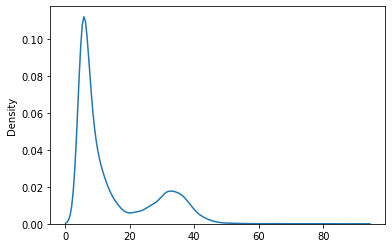

In [106]:
def critic(x):
    if x < mmin:
        return 0
    else:
        return mix.log_prob(x).exp()

from tqdm import trange

def mh():
    x = torch.rand(1) + mmin
    step_size = 1
    delta_step_size = 1e-3
    decisions = []
    samples = []
    
    for i in trange(32768):
        if i > 1024:
            samples.append(x)
            
        x_ = x + torch.randn(1) * step_size
        
#         ratio = torch.exp(g.log_prob(transform_x(x_)) - g.log_prob(transform_x(x)))
#         ratio = torch.exp(g.log_prob(x_) - g.log_prob(x))
        ratio = critic(x_) / critic(x)
        u = torch.rand(1)
        
        if u > ratio:
            decisions.append(0)
        else:
            decisions.append(1)
            x = x_
        
        accept_ratio = sum(decisions) / len(decisions)

        if accept_ratio < 0.8:
            step_size *= .99
        else:
            step_size /= .99
            
        decisions = decisions[-256:]
        print(accept_ratio, x.item(), step_size)


            
    return samples
        

        

z = mh()

sns.kdeplot(torch.stack(z).flatten().numpy())

In [222]:
def critic(x):
    if (x < mmin) or (x > mmax):
        return -float('inf')
    else:
        return mix.log_prob(x)

from tqdm import trange

def mh():
    x = torch.rand(1) + mmin
    step_size = 1
    delta_step_size = 1e-3
    decisions = []
    samples = []
    
    for i in trange(32768):
        if i > 1024:
            samples.append(x)
            
        x_ = x + torch.randn(1) * step_size
        
#         ratio = torch.exp(g.log_prob(transform_x(x_)) - g.log_prob(transform_x(x)))
#         ratio = torch.exp(g.log_prob(x_) - g.log_prob(x))
        ratio = critic(x_) - critic(x)
        u = torch.rand(1).log()
        
        ratio_ = math.exp(critic(x_)) / math.exp(critic(x))
        
        assert torch.all((u > ratio) == (u.exp() > ratio_)), (x, x_, u)
        
        if u > ratio:
            decisions.append(0)
        else:
            decisions.append(1)
            x = x_
        
        accept_ratio = sum(decisions) / len(decisions)

        if accept_ratio < 0.234:
            step_size *= .999
        else:
            step_size /= .999
            
        decisions = decisions[-256:]
        print(accept_ratio, x.item(), step_size)


            
    return samples
        

        

z = mh()

sns.kdeplot(torch.stack(z).flatten().numpy())

  0%|▏                                              | 148/32768 [00:00<00:22, 1473.78it/s]

1.0 4.970203876495361 1.001001001001001
0.5 4.970203876495361 1.002003004005006
0.6666666666666666 5.723128795623779 1.003006010015021
0.75 5.393440246582031 1.0040100200350561
0.6 5.393440246582031 1.0050150350701264
0.6666666666666666 6.144510269165039 1.0060210561262526
0.7142857142857143 4.698411464691162 1.007028084210463
0.625 4.698411464691162 1.008036120330794
0.5555555555555556 4.698411464691162 1.0090451654962902
0.5 4.698411464691162 1.0100552207170073
0.5454545454545454 5.6122822761535645 1.0110662870040112
0.5833333333333334 5.832467555999756 1.0120783653693806
0.5384615384615384 5.832467555999756 1.0130914568262068
0.5714285714285714 5.608138561248779 1.0141055623885955
0.5333333333333333 5.608138561248779 1.0151206830716673
0.5 5.608138561248779 1.0161368198915588
0.47058823529411764 5.608138561248779 1.0171539738654243
0.5 5.007096767425537 1.0181721460114357
0.5263157894736842 6.0996174812316895 1.0191913373487844
0.55 5.312117099761963 1.0202115488976822
0.52380952380

  1%|▋                                              | 450/32768 [00:00<00:22, 1420.20it/s]

0.7782101167315175 11.597705841064453 1.32199187189348
0.7782101167315175 11.4537353515625 1.3233151870805606
0.7782101167315175 9.184392929077148 1.3246398269074682
0.7782101167315175 7.56429386138916 1.3259657927001685
0.7782101167315175 8.39224624633789 1.3272930857859544
0.7782101167315175 8.346935272216797 1.3286217074934479
0.7782101167315175 9.335938453674316 1.3299516591526004
0.7821011673151751 11.310005187988281 1.331282942094695
0.7821011673151751 8.149313926696777 1.3326155576523473
0.7821011673151751 8.396148681640625 1.3339495071595069
0.7859922178988327 7.331745624542236 1.3352847919514583
0.7859922178988327 5.459696292877197 1.336621413364823
0.7898832684824902 9.083317756652832 1.3379593727375607
0.7898832684824902 9.642276763916016 1.3392986714089696
0.7937743190661478 8.835967063903809 1.3406393107196892
0.7937743190661478 6.925334930419922 1.341981292011701
0.7898832684824902 6.925334930419922 1.3433246166283292
0.7898832684824902 7.974907398223877 1.344669285914243

  2%|█                                              | 732/32768 [00:00<00:23, 1372.20it/s]

0.6926070038910506 30.78390121459961 1.7564270981275762
0.6964980544747081 27.413330078125 1.7581852834109872
0.6926070038910506 27.413330078125 1.7599452286396269
0.6926070038910506 25.631032943725586 1.7617069355752022
0.6926070038910506 27.44704818725586 1.7634704059811834
0.6926070038910506 27.980735778808594 1.7652356416228063
0.6926070038910506 28.346054077148438 1.7670026442670734
0.688715953307393 28.346054077148438 1.768771415682756
0.6926070038910506 27.33177947998047 1.7705419576403965
0.6964980544747081 27.200115203857422 1.7723142719123088
0.6964980544747081 27.11556053161621 1.7740883602725814
0.6926070038910506 27.11556053161621 1.7758642244970786
0.6926070038910506 27.40770149230957 1.7776418663634421
0.6926070038910506 27.540416717529297 1.7794212876510933
0.6926070038910506 31.245010375976562 1.7812024901412344
0.6964980544747081 33.35120391845703 1.7829854756168513
0.6964980544747081 34.541587829589844 1.784770245862714
0.6964980544747081 33.25205993652344 1.78655680

  3%|█▍                                            | 1020/32768 [00:00<00:22, 1401.44it/s]

0.9066147859922179 41.1696891784668 2.3011679027826863
0.9066147859922179 43.49657440185547 2.3034713741568433
0.9066147859922179 38.088417053222656 2.3057771513081513
0.9066147859922179 37.26317596435547 2.308085236544696
0.9066147859922179 37.683753967285156 2.310395632176873
0.9066147859922179 37.59657287597656 2.31270834051739
0.9066147859922179 37.270668029785156 2.3150233638812714
0.9027237354085603 37.270668029785156 2.3173407045858574
0.9027237354085603 39.05512619018555 2.319660364950808
0.9027237354085603 40.0999755859375 2.321982347298106
0.8988326848249028 40.0999755859375 2.3243066539520583
0.8988326848249028 40.93179702758789 2.3266332872392974
0.8988326848249028 42.95751953125 2.3289622494887863
0.8988326848249028 43.188533782958984 2.3312935430318182
0.8988326848249028 42.416053771972656 2.3336271702020204
0.8988326848249028 41.60384750366211 2.3359631333353557
0.8949416342412452 41.60384750366211 2.3383014347701256
0.8949416342412452 38.07740020751953 2.340642076846972

  4%|█▊                                            | 1324/32768 [00:00<00:21, 1460.39it/s]

0.8443579766536965 20.226730346679688 3.125423768615438
0.8443579766536965 15.692042350769043 3.1285523209363744
0.8443579766536965 20.038909912109375 3.1316840049413157
0.8443579766536965 23.45151710510254 3.1348188237650807
0.8443579766536965 25.79722785949707 3.1379567805456263
0.8443579766536965 32.705833435058594 3.14109787842405
0.8443579766536965 33.60350036621094 3.144242120544595
0.8443579766536965 34.316436767578125 3.1473895100546496
0.8443579766536965 34.743804931640625 3.1505400501047545
0.8443579766536965 35.922611236572266 3.1536937438486032
0.8443579766536965 32.76331329345703 3.1568505944430463
0.8443579766536965 38.39903259277344 3.1600106050480945
0.8443579766536965 37.93452835083008 3.1631737788269216
0.8443579766536965 37.799190521240234 3.1663401189458673
0.8404669260700389 37.799190521240234 3.169509628574442
0.8404669260700389 37.88692855834961 3.1726823108853273
0.8404669260700389 43.61064529418945 3.1758581690543815
0.8404669260700389 39.379981994628906 3.1790

  5%|██▎                                           | 1637/32768 [00:01<00:20, 1518.02it/s]

0.8054474708171206 11.81818675994873 4.240675114533115
0.8054474708171206 14.623493194580078 4.2449200345676825
0.8054474708171206 15.095521926879883 4.249169203771454
0.8093385214007782 10.812324523925781 4.253422626397852
0.8132295719844358 12.266724586486816 4.2576803067045565
0.8132295719844358 11.255922317504883 4.26194224895351
0.8132295719844358 12.72441577911377 4.2662084574109205
0.8171206225680934 13.00056266784668 4.270478936347268
0.8171206225680934 18.539392471313477 4.274753690037305
0.8171206225680934 18.74824333190918 4.279032722760065
0.8171206225680934 20.720844268798828 4.283316038798864
0.8171206225680934 25.779739379882812 4.287603642441305
0.8132295719844358 25.779739379882812 4.2918955379792845
0.8171206225680934 22.035825729370117 4.296191729708993
0.8171206225680934 18.46502685546875 4.300492221930924
0.8171206225680934 20.034929275512695 4.304797018949873
0.8210116731517509 23.998775482177734 4.3091061250749485
0.8210116731517509 25.006147384643555 4.313419544

  6%|██▊                                           | 1978/32768 [00:01<00:19, 1609.13it/s]

0.4591439688715953 29.772960662841797 5.94108094512388
0.4591439688715953 23.20053482055664 5.947027973096977
0.46303501945525294 26.523725509643555 5.952980954051028
0.4669260700389105 24.2840518951416 5.958939893944972
0.4708171206225681 25.413330078125 5.964904798743716
0.47470817120622566 31.57488250732422 5.970875674418134
0.47470817120622566 31.57488250732422 5.97685252694508
0.47470817120622566 34.96119689941406 5.982835362307387
0.47470817120622566 30.52412223815918 5.988824186493881
0.4708171206225681 30.52412223815918 5.99481900549938
0.4708171206225681 34.10152053833008 6.0008198253247045
0.4708171206225681 35.0131721496582 6.006826651976681
0.47470817120622566 31.972047805786133 6.012839491468149
0.4785992217898833 36.566810607910156 6.018858349817967
0.48249027237354086 22.685462951660156 6.0248832330510185
0.48638132295719844 13.182421684265137 6.030914147198216
0.48638132295719844 20.756521224975586 6.036951098296513
0.490272373540856 18.745529174804688 6.042994092388902

  7%|███▏                                          | 2304/32768 [00:01<00:19, 1585.66it/s]

0.5019455252918288 31.6572208404541 8.32330745535079
0.5019455252918288 40.98584747314453 8.331639094445235
0.5019455252918288 34.66628646850586 8.339979073518753
0.4980544747081712 34.66628646850586 8.348327400919674
0.4980544747081712 33.4169921875 8.356684085004678
0.4980544747081712 33.75575637817383 8.365049134138816
0.5019455252918288 35.216270446777344 8.373422556695512
0.5019455252918288 37.302040100097656 8.381804361056568
0.5019455252918288 27.396772384643555 8.390194555612181
0.4980544747081712 27.396772384643555 8.398593148760943
0.4980544747081712 26.271482467651367 8.407000148909853
0.4980544747081712 40.34788513183594 8.415415564474328
0.4980544747081712 42.63104248046875 8.423839403878207
0.4980544747081712 42.82298278808594 8.43227167555376
0.49416342412451364 42.82298278808594 8.440712387941701
0.49416342412451364 35.96060562133789 8.449161549491192
0.49416342412451364 35.96060562133789 8.457619168659852
0.49416342412451364 24.82589340209961 8.466085253913766
0.498054

  8%|███▋                                          | 2622/32768 [00:01<00:19, 1580.08it/s]

0.5719844357976653 34.27381134033203 11.384084812869327
0.5719844357976653 25.48983383178711 11.395480293162489
0.5680933852140078 25.48983383178711 11.406887180342832
0.5680933852140078 25.590038299560547 11.418305485828661
0.5642023346303502 25.590038299560547 11.429735221049711
0.5680933852140078 30.853181838989258 11.441176397447158
0.5680933852140078 32.755794525146484 11.452629026473632
0.5680933852140078 33.77632141113281 11.464093119593226
0.5680933852140078 33.77632141113281 11.475568688281507
0.5680933852140078 32.2789306640625 11.487055744025533
0.5680933852140078 26.604076385498047 11.498554298323857
0.5680933852140078 31.438705444335938 11.510064362686544
0.5680933852140078 34.323036193847656 11.52158594863518
0.5680933852140078 32.967262268066406 11.533119067702883
0.5719844357976653 39.152889251708984 11.544663731434317
0.5719844357976653 42.982967376708984 11.556219951385703
0.5719844357976653 41.194374084472656 11.567787739124828
0.5719844357976653 41.194374084472656 1

  9%|████                                          | 2938/32768 [00:01<00:19, 1552.97it/s]

0.45525291828793774 35.03007888793945 15.523754735867838
0.45525291828793774 35.03007888793945 15.539294029897736
0.4591439688715953 32.69557189941406 15.554848878776513
0.46303501945525294 28.67713737487793 15.570419298074587
0.4669260700389105 28.74441909790039 15.586005303377965
0.4708171206225681 7.6234130859375 15.601606910288252
0.4708171206225681 7.6234130859375 15.617224134422674
0.47470817120622566 19.381948471069336 15.632856991414089
0.4785992217898833 16.504764556884766 15.648505496911
0.47470817120622566 16.504764556884766 15.664169666577576
0.4708171206225681 16.504764556884766 15.67984951609367
0.4669260700389105 16.504764556884766 15.695545061154824
0.4708171206225681 21.210430145263672 15.711256317472296
0.4708171206225681 4.729969024658203 15.72698330077307
0.4669260700389105 4.729969024658203 15.742726026799868
0.4669260700389105 4.729969024658203 15.75848451131118
0.4669260700389105 4.729969024658203 15.77425877008126
0.46303501945525294 4.729969024658203 15.7900488

 10%|████▌                                         | 3261/32768 [00:02<00:18, 1567.01it/s]

0.33073929961089493 26.83184814453125 21.44589007456234
0.33073929961089493 26.83184814453125 21.467357431994333
0.32684824902723736 26.83184814453125 21.488846278272607
0.3229571984435798 26.83184814453125 21.510356634907517
0.3229571984435798 9.258743286132812 21.531888523430947
0.31906614785992216 9.258743286132812 21.553441965396342
0.3151750972762646 9.258743286132812 21.57501698237872
0.3151750972762646 8.99095344543457 21.596613595974695
0.311284046692607 8.99095344543457 21.618231827802497
0.30739299610894943 8.99095344543457 21.639871699502
0.3035019455252918 8.99095344543457 21.661533232734733
0.29961089494163423 8.99095344543457 21.683216449183917
0.29961089494163423 8.82763671875 21.70492137055447
0.29571984435797666 8.82763671875 21.72664801857304
0.29571984435797666 8.82763671875 21.74839641498803
0.29571984435797666 28.8618221282959 21.770166581569597
0.2918287937743191 28.8618221282959 21.791958540109707
0.2918287937743191 28.8618221282959 21.81377231242213
0.2918287937

 11%|█████                                         | 3584/32768 [00:02<00:18, 1588.20it/s]

0.32684824902723736 27.492130279541016 29.538459580666835
0.32684824902723736 29.505352020263672 29.56802760827511
0.32684824902723736 29.505352020263672 29.59762523350862
0.32684824902723736 29.505352020263672 29.627252485994614
0.32684824902723736 34.86418914794922 29.656909395390002
0.32684824902723736 34.86418914794922 29.686595991381385
0.33073929961089493 32.86883544921875 29.71631230368507
0.3346303501945525 31.327951431274414 29.746058362047116
0.33073929961089493 31.327951431274414 29.77583419624336
0.32684824902723736 31.327951431274414 29.80563983607944
0.32684824902723736 31.327951431274414 29.83547531139083
0.3229571984435798 31.327951431274414 29.865340652042875
0.32684824902723736 30.61731719970703 29.895235887930806
0.32684824902723736 37.31395721435547 29.925161048979785
0.32684824902723736 37.31395721435547 29.95511616514493
0.3229571984435798 37.31395721435547 29.98510126641134
0.3229571984435798 37.31395721435547 30.015116382794137
0.31906614785992216 37.31395721435

 12%|█████▍                                        | 3901/32768 [00:02<00:18, 1531.19it/s]

0.22957198443579765 31.812108993530273 40.159006288168
0.22957198443579765 31.812108993530273 40.11884728187983
0.22957198443579765 31.812108993530273 40.07872843459795
0.22957198443579765 31.812108993530273 40.03864970616335
0.23346303501945526 34.303260803222656 39.998611056457186
0.23346303501945526 34.303260803222656 39.95861244540073
0.22957198443579765 34.303260803222656 39.91865383295533
0.22957198443579765 34.303260803222656 39.87873517912237
0.22957198443579765 34.303260803222656 39.83885644394325
0.22957198443579765 34.303260803222656 39.79901758749931
0.22957198443579765 34.303260803222656 39.75921856991181
0.22568093385214008 34.303260803222656 39.7194593513419
0.22568093385214008 34.303260803222656 39.67973989199056
0.22178988326848248 34.303260803222656 39.64006015209857
0.22178988326848248 34.303260803222656 39.600420091946475
0.22178988326848248 34.303260803222656 39.56081967185453
0.22568093385214008 25.29936408996582 39.521258852182676
0.22568093385214008 25.299364089

KeyboardInterrupt: 

In [319]:
n_samples = 1024

In [320]:
t0 = mix.sample(n_samples)

In [321]:
std = 1

In [322]:
data = torch.distributions.Normal(t0.sqrt(), torch.tensor([std])).sample()

In [323]:
def critic(x):
    densities = torch.full((n_samples,), -torch.inf)
    mask = (x > mmin) & (x < mmax)
    x = x[mask]
    prior = mix.log_prob(x)
    likelihood = torch.distributions.Normal(x.sqrt(), 1).log_prob(data[mask])
    densities[mask] = prior + likelihood
    return densities

In [324]:
def rand_between(shape, low, high):
    return torch.Tensor(*shape).uniform_(low, high)

In [325]:
def mh_batch():
    x = rand_between((n_samples,), mmin, mmax)
    step_sizes = torch.ones(n_samples)
    decisions = []
    samples = []
    
    assert torch.isfinite(critic(x)).all()
    
    for i in trange(32768):
        if i > 1024:
            samples.append(x.clone())
        
        x_ = x + torch.randn(n_samples) * step_sizes
        
        ratios = critic(x_) - critic(x)
    
        u = torch.rand(n_samples).log()
        
        accepts = u <= ratios
        decisions.append(accepts)
        
        x[accepts] = x_[accepts]
        
        accept_ratios = torch.mean(torch.stack(decisions).float(), dim=0)

        step_sizes[accept_ratios < 0.234] *= 0.999
        step_sizes[accept_ratios >= 0.234] /= 0.999
            
        decisions = decisions[-512:]
#         print(accept_ratios, x, step_sizes)
        if i > 4096 and i % 128 == 0:
            mask = accept_ratios == 0
            assert not torch.any(accept_ratios == 0), print("Try increasing initial step size.")
            assert not torch.any(accept_ratios == 1)



            
    return samples
        

        

In [326]:
samples = mh_batch()

100%|████████████████████████████████████████| 32768/32768 [01:25<00:00, 381.42it/s]


In [327]:
samples = torch.stack(samples)

In [328]:
samples.shape

torch.Size([31743, 1024])

<AxesSubplot:ylabel='Density'>

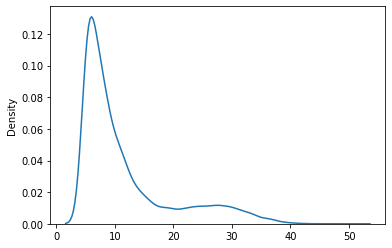

In [329]:
# Posterior
sns.kdeplot(samples[:, 0])

<AxesSubplot:ylabel='Density'>

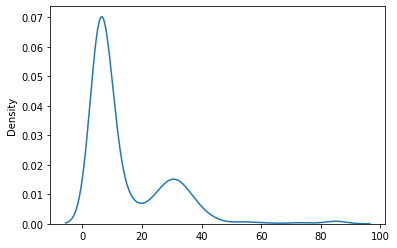

In [330]:
# Marginal
sns.kdeplot(samples[5, :])

In [ ]:
num_samples = 1024
std = 1
theta = mix.sample(num_samples).squeeze()
p_x_theta = torch.distributions.Normal(theta, torch.tensor([std]))
data = p_x_theta.sample()

def potential(theta):
    densities = torch.zeros(len(theta))
    
    mask = (theta > mmin) & (theta < mmax)
    
    prior = mix.log_prob(theta[mask])
    likelihood = torch.distributions.Normal(theta[mask], torch.tensor([std])).log_prob(data[mask])
    densities[mask] = torch.exp(prior + likelihood)
#     densities[mask] = torch.exp(likelihood)
#     densities[mask] = torch.exp(prior)
        

#     print(mask)
    return densities

In [ ]:
def mh_batch(critic):
    x = rand_between((num_samples,), mmin, mmax)
    step_sizes = torch.ones(num_samples) * 1
    delta_step_size = 1e-3
    decisions = []
    samples = []
        
    for i in trange(1024 + 32768 + 1):
        if i > 1024:
            samples.append(x.clone())
        
#         print(x)
        x_ = x + torch.randn(num_samples) * step_sizes

        
#         ratio = torch.exp(g.log_prob(transform_x(x_)) - g.log_prob(transform_x(x)))
#         ratio = torch.exp(g.log_prob(x_) - g.log_prob(x))
        ratios = critic(x_) / critic(x)
    
        u = torch.rand(num_samples)
        
        accepts = u <= ratios
        decisions.append(accepts)
        
        x[accepts] = x_[accepts]
        
        accept_ratios = torch.mean(torch.stack(decisions).float(), dim=0)

        step_sizes[accept_ratios < 0.234] *= 0.999
        step_sizes[accept_ratios >= 0.234] /= 0.999

            
        decisions = decisions[-256:]
#         print(accept_ratios, x, step_sizes)
        if i > 1024 and i % 128 == 0:
            print(accept_ratios, step_sizes, x)
            
            assert not torch.any(accept_ratios == 0)
            assert not torch.any(accept_ratios == 1)
    

            
    return samples
        

        

In [ ]:
posterior_samples = mh_batch(potential)

In [ ]:
posterior_samples = torch.stack(posterior_samples)

In [ ]:
marginal = posterior_samples.mean(0)
sns.kdeplot(marginal)

In [ ]:
posterior = posterior_samples[256, :]
sns.kdeplot(posterior)